In [66]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as st
import multiprocessing as mp
from sklearn.decomposition import PCA

#Save
import json, h5py
import scipy.io as sio

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

#Predictive Coding Github Repository
sys.path.append('/home/dwyrick/Git/openscope_predictive_coding/')
from openscope_predictive_coding.ophys.dataset.openscope_predictive_coding_dataset import OpenScopePredictiveCodingDataset
from openscope_predictive_coding.ophys.response_analysis.response_analysis import ResponseAnalysis

#User
import openscope_predictive_coding.ophys.decoding_analysis.decoding as dc
import openscope_predictive_coding.ophys.response_analysis.utilities as openscope_utils

#Params
mainseq_ids = [68, 78, 13, 26]
oddball_ids = [6, 17, 22, 51, 71, 89, 103, 110, 111, 112]

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# data streams for each imaging session are saved as .h5 files in each folder's experiment in this directory
cache_dir = '/srv/data/AllenInst/opc_analysis'

# Read in experiment manifest
manifest_file = '/srv/data/AllenInst/opc_analysis/opc_production_manifest.xlsx'
manifest = pd.read_excel(manifest_file)

# limit to experiments that passed QC
manifest = manifest[manifest['experiment_state']=='passed']
areanames = np.unique(manifest['imaging_area'])

In [3]:
manifest.head()

workflow_state experiment_state  mouse_id  experiment_id  session_id  \
4        uploaded           passed    416366    768898762.0   768476976   
6        uploaded           passed    416366    775058863.0   774663713   
7        uploaded           passed    416366    775613721.0   775204389   
8        uploaded           passed    416366    776727982.0   775841272   
10       uploaded           passed    432373    813071318.0   812785966   

                             genotype  imaging_depth imaging_area  \
4   Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93            185          RSP   
6   Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93            350          RSP   
7   Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93            175        VISpm   
8   Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93            420        VISpm   
10  Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93            450         VISp   

   injection_area  acquisition_date                          name      rig  \
4            VISp  10/25/2018 10:30             20181025_416366_1  CAM2P.1   
6            VISp  11/07/2018 09:56             20181107_416366_2  CAM2P.2   
7            VISp  11/08/2018 09:13             20181108_416366_3  CAM2P.2   
8            VISp  11/09/2018 09:55             20181109_416366_4  CAM2P.2   
10            RSP  01/24/2019 09:11  20190124_432373_predictcode2  CAM2P.2   

   operator  specimen_id                                          notes  \
4      sams    753787399                                            NaN   
6      sams    753787399                                            NaN   
7      sams    753787399  epilepsy probability,jerome okayed to pass-JL   
8      sams    753787399                                            NaN   
10     sams    791753881                                            NaN   

                 project_code          failure_tags qc_reviewer  
4   OpenScopePredictiveCoding                   NaN   jenniferl  
6   OpenScopePredictiveCoding                   NaN   jenniferl  
7   OpenScopePredictiveCoding  epilepsy_probability   jenniferl  
8   OpenScopePredictiveCoding                   NaN        sams  
10  OpenScopePredictiveCoding                   NaN       joshl

In [6]:
data = sio.loadmat('/home/dwyrick/projects/predictive_coding/data/preferredStim.mat')
data
preferred_imageIDs = data['preferred_imageIDs'][0]
cellIDs = data['cellIDs'][0]

In [7]:
os.getcwd()
os.chdir('/home/dwyrick/projects/predictive_coding')
os.getcwd()

'/home/dwyrick/projects/predictive_coding'

In [8]:
cell_metadata_df = pd.read_csv('/home/dwyrick/projects/predictive_coding/cell_metadata.csv')
cell_metadata_df.drop(columns='Unnamed: 0',inplace=True)
cell_metadata_df.drop_duplicates(subset='cell_specimen_id',inplace=True)
cell_metadata_df.set_index('cell_specimen_id', drop=True, inplace=True)


pIDs = []
for cellID in cell_metadata_df.index.values:
    
    indy = np.where(cellIDs == cellID)[0][0]
    pID = preferred_imageIDs[indy]

    pIDs.append(pID)
    
cell_metadata_df['pref_stim'] = pIDs


In [ ]:
# Concatenate data from all experiments to create pseudopopulation response arrays
# This cell takes a while to run, which is why I've split up the functions of getting the data and selecting the data we want to decode with
randctrl_pseudopop_responses = {}
transctrl_pseudopop_responses = {}
oddball_pseudopop_responses = {}

area = 'VISpm'
for area in areanames:
    #For oddball block
    X_oddball, stimulus_df = dc.create_psuedopopulation(manifest, area, block='oddball')
    oddball_pseudopop_responses[area] = X_oddball

    #For randomized control pre block
    X_randctrl_pre, stimulus_df = dc.create_psuedopopulation(manifest, area, block='randomized_control_pre')

    #For randomized control pre block
    X_randctrl_post, stimulus_df = dc.create_psuedopopulation(manifest, area, block='randomized_control_post')
    randctrl_pseudopop_responses[area] = [X_randctrl_pre, X_randctrl_post]

    #For transition control block
    X_transctrl, stimulus_df = dc.create_psuedopopulation(manifest, area, block='transition_control')
    transctrl_pseudopop_responses[area] = X_transctrl
    

In [18]:
# Get data per session 
# This cell takes a while to run, which is why I've split up the functions of getting the data and selecting the data we want to decode with

randctrl_pop_responses, transctrl_pop_responses, oddball_pop_responses, stimulus_df = dc.get_responses_per_session(manifest,  use_events=True, variable='summed_response')


RSP: 
768898762, 775058863, 848005700, 848006710, 830688102, 832601977, 833614835, 834260382, 833612445, 836906598, 834244626, 836250018, 
VISp: 
813071318, 817251851, 826576489, 827232898, 848690810, 830075254, 830688059, 835642229, 835654507, 833626456, 836248932, 827235482, 828959377, 833611925, 834251985, 
VISpm: 
775613721, 776727982, 816795279, 818894752, 828956958, 829411383, 832617299, 833599179, 831312165, 832107135, 838330377, 836246273, 836891984, 837630919, 837287590, 829417358, 831314921, 835660148, 836253258, 837285285, 836890936, 837283374, 

In [41]:
cell_metadata_df


experiment_id  experiment_container_id targeted_structure  \
cell_specimen_id                                                              
768915941             768898762                      NaN                RSP   
768915947             768898762                      NaN                RSP   
768915949             768898762                      NaN                RSP   
768915951             768898762                      NaN                RSP   
768915959             768898762                      NaN                RSP   
...                         ...                      ...                ...   
838809358             838330377                      NaN              VISpm   
838809365             838330377                      NaN              VISpm   
838809371             838330377                      NaN              VISpm   
838809373             838330377                      NaN              VISpm   
838809379             838330377                      NaN              VISpm   

                  imaging_depth cre_line    reporter_line  \
cell_specimen_id                                            
768915941                   185  Slc17a7  Camk2a-tTA;Ai93   
768915947                   185  Slc17a7  Camk2a-tTA;Ai93   
768915949                   185  Slc17a7  Camk2a-tTA;Ai93   
768915951                   185  Slc17a7  Camk2a-tTA;Ai93   
768915959                   185  Slc17a7  Camk2a-tTA;Ai93   
...                         ...      ...              ...   
838809358                   375  Slc17a7  Camk2a-tTA;Ai93   
838809365                   375  Slc17a7  Camk2a-tTA;Ai93   
838809371                   375  Slc17a7  Camk2a-tTA;Ai93   
838809373                   375  Slc17a7  Camk2a-tTA;Ai93   
838809379                   375  Slc17a7  Camk2a-tTA;Ai93   

                            full_genotype        session_type  donor_id  \
cell_specimen_id                                                          
768915941         Slc17a7;Camk2a-tTA;Ai93  behavior_session_1    416366   
768915947         Slc17a7;Camk2a-tTA;Ai93  behavior_session_1    416366   
768915949         Slc17a7;Camk2a-tTA;Ai93  behavior_session_1    416366   
768915951         Slc17a7;Camk2a-tTA;Ai93  behavior_session_1    416366   
768915959         Slc17a7;Camk2a-tTA;Ai93  behavior_session_1    416366   
...                                   ...                 ...       ...   
838809358         Slc17a7;Camk2a-tTA;Ai93  behavior_session_4    438382   
838809365         Slc17a7;Camk2a-tTA;Ai93  behavior_session_4    438382   
838809371         Slc17a7;Camk2a-tTA;Ai93  behavior_session_4    438382   
838809373         Slc17a7;Camk2a-tTA;Ai93  behavior_session_4    438382   
838809379         Slc17a7;Camk2a-tTA;Ai93  behavior_session_4    438382   

                 experiment_date  specimen_id        depth         location  \
cell_specimen_id                                                              
768915941             2018-10-25    753787399  superficial  RSP_superficial   
768915947             2018-10-25    753787399  superficial  RSP_superficial   
768915949             2018-10-25    753787399  superficial  RSP_superficial   
768915951             2018-10-25    753787399  superficial  RSP_superficial   
768915959             2018-10-25    753787399  superficial  RSP_superficial   
...                          ...          ...          ...              ...   
838809358             2019-03-12    807303822         deep       VISpm_deep   
838809365             2019-03-12    807303822         deep       VISpm_deep   
838809371             2019-03-12    807303822         deep       VISpm_deep   
838809373             2019-03-12    807303822         deep       VISpm_deep   
838809379             2019-03-12    807303822         deep       VISpm_deep   

                 session_num   area  retrogradely_labeled imaging_area  \
cell_specimen_id                                                         
768915941                  1    RSP         

In [31]:
areanames = ['VISp','VISpm','RSP']

In [ ]:
##===== Let's decode stimulus blocks from each other based on responses to MS images =====##
method='L1O'
classifier = 'nearest_neighbor'

nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

#Where to save
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
PlotDir = os.path.join(SaveDir,'plots')

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areas
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(oddball_pop_responses[area].keys())
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')
        
        confusion_mat_list = []; confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []
        
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)
            
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')
            if nNeurons < 20:
                continue
            
            #Preallocate
            confusion_mat = np.zeros((4,nClasses,nClasses))
            confusion_shf = np.zeros((4,nClasses,nClasses))
            confusion_z = np.zeros((4,nClasses,nClasses))
        
            #Get data for this area for each stimulus block
            X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pop_responses[area][eID][0].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))
            X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
            X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pop_responses[area][eID][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
            
            for iImg, img_ID in enumerate(mainseq_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_pre = np.where(Y_randctrl_pre == img_ID)[0]
                indy_oddball = np.where(Y_oddball == img_ID)[0]
                indy_transctrl = np.where(Y_transctrl == img_ID)[0]
                indy_post = np.where(Y_randctrl_post == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_randctrl_pre[indy_pre,:],X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:],X_randctrl_post[indy_post,:]))
                Y = np.hstack([np.repeat(i,30) for i in range(nClasses)])
                
                #Perform Cross-validation
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
                
            diag_hits = np.concatenate([np.diag(confusion_mat[i]) for i in range(nClasses)])
            offdiag_hits = np.concatenate([confusion_mat[i][off_diagonal_indy] for i in range(nClasses)])
            
            offdiag_hits_list.append(np.mean(offdiag_hits)); diag_hits_list.append(np.mean(diag_hits))
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        #Save decoding results
        fpath = os.path.join(SaveDir,'StimulusBlocks_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
            
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0)
        confusion_z_mean = np.mean(confusion_z_list,axis=0)
        
        #Plot shuffle distributions
        dc.plot_confusion_matrices(confusion_mat_mean,confusion_z_mean,plot_titles=['A','B','C','D'],class_labels=['rand-pre','OB', 'Trans','rand-post'])
        plt.suptitle('Classifying Stimulus Condition for area {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'StimulusBlocks_avg-over-ms_avg-over-eIDs_{}_{}_{}.png'.format(locstr,method,classifier)))
        
        #Sparate diagonal and off-diagonal performance
        diag_hits_z = np.concatenate([np.diag(cm[i])  for cm in confusion_z_list for i in range(nClasses)])
        offdiag_hits_z = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_z_list for i in range(nClasses)])
        
        axes2[jj,ii].set_title(f'{locstr}:\n {len(offdiag_hits_list)} sessions')
#         axes2[jj,ii].boxplot([diag_hits_z,offdiag_hits_z])
        axes2[jj,ii].boxplot([diag_hits_list,offdiag_hits_list])
        
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance\n per session')
            
fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to MS images',y=1.01)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_usingMSimgs{}_{}.png'.format(method,classifier)))

VISp_superficial:	
813071318.0 -> 0 neurons
817251851.0 -> 239 neurons
826576489.0 -> 64 neurons
827232898.0 -> 0 neurons
848690810.0 -> 0 neurons
830075254.0 -> 282 neurons
830688059.0 -> 0 neurons
835642229.0 -> 303 neurons
835654507.0 -> 0 neurons
833626456.0 -> 116 neurons
836248932.0 -> 0 neurons
827235482.0 -> 70 neurons
828959377.0 -> 0 neurons
833611925.0 -> 204 neurons
834251985.0 -> 0 neurons
VISp_deep:	
813071318.0 -> 98 neurons
817251851.0 -> 0 neurons
826576489.0 -> 0 neurons
827232898.0 -> 75 neurons
848690810.0 -> 0 neurons
830075254.0 -> 0 neurons
830688059.0 -> 124 neurons
835642229.0 -> 0 neurons
835654507.0 -> 356 neurons
833626456.0 -> 0 neurons
836248932.0 -> 93 neurons
827235482.0 -> 0 neurons
828959377.0 -> 74 neurons
833611925.0 -> 0 neurons
834251985.0 -> 139 neurons
VISpm_superficial:	
775613721.0 -> 81 neurons
776727982.0 -> 0 neurons
816795279.0 -> 0 neurons
818894752.0 -> 93 neurons


VISp_superficial:	
813071318.0 -> 0 neurons
817251851.0 -> 239 neurons
826576489.0 -> 64 neurons
827232898.0 -> 0 neurons
848690810.0 -> 0 neurons
830075254.0 -> 282 neurons
830688059.0 -> 0 neurons
835642229.0 -> 303 neurons
835654507.0 -> 0 neurons
833626456.0 -> 116 neurons
836248932.0 -> 0 neurons
827235482.0 -> 70 neurons
828959377.0 -> 0 neurons
833611925.0 -> 204 neurons
834251985.0 -> 0 neurons
VISp_deep:	
813071318.0 -> 98 neurons
817251851.0 -> 0 neurons
826576489.0 -> 0 neurons
827232898.0 -> 75 neurons
848690810.0 -> 0 neurons
830075254.0 -> 0 neurons
830688059.0 -> 124 neurons
835642229.0 -> 0 neurons
835654507.0 -> 356 neurons
833626456.0 -> 0 neurons
836248932.0 -> 93 neurons
827235482.0 -> 0 neurons
828959377.0 -> 74 neurons
833611925.0 -> 0 neurons
834251985.0 -> 139 neurons
VISpm_superficial:	
775613721.0 -> 81 neurons
776727982.0 -> 0 neurons
816795279.0 -> 0 neurons
818894752.0 -> 93 neurons
828956958.0 -> 43 neurons
829411383.0 -> 0 neurons
832617299.0 -> 61 neuron

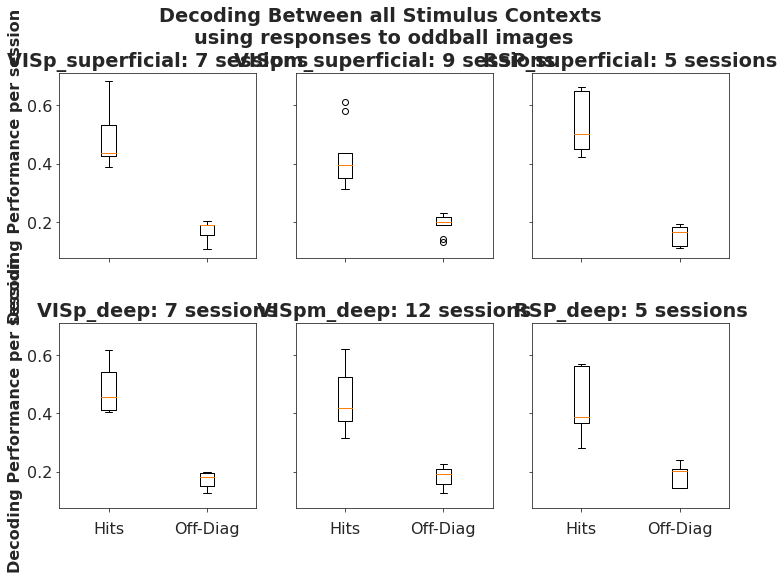

In [65]:
##===== Let's decode stimulus blocks from each other based on responses to oddball images =====##
method='kfold'
classifier = 'nearest_neighbor'

nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

#Where to save
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
PlotDir = os.path.join(SaveDir,'plots')

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areasconfusion_z_mean
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(oddball_pop_responses[area].keys())
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')
        
        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)
            
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')
            if nNeurons < 20:
                continue
                    
            #Get data for this area for each stimulus block
            X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pop_responses[area][eID][0].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='X')
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X',trial_indy=slice(740,860))
            X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')
            X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pop_responses[area][eID][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='X')
            
            
            indy_list = []; indy_list2 = []; indy_list3 = []
            for iImg, img_ID in enumerate(oddball_ids):
                tmp = np.where(Y_randctrl_pre == img_ID)[0]
                np.random.shuffle(tmp)
                indy_list.append(tmp[:10])

                tmp = np.where(Y_randctrl_post == img_ID)[0]
                np.random.shuffle(tmp)
                indy_list2.append(tmp[:10])

                tmp = np.where(Y_transctrl == img_ID)[0]
                np.random.shuffle(tmp)
                indy_list3.append(tmp[:10])

            indy_randctrlpre = np.concatenate(indy_list)
            indy_randctrlpost = np.concatenate(indy_list2)
            indy_transctrl = np.concatenate(indy_list3)

            #Construct X and Y from both blocks
            X = np.vstack((X_randctrl_pre[indy_randctrlpre,:],X_oddball,X_transctrl[indy_transctrl,:],X_randctrl_post[indy_randctrlpost,:]))
            Y = np.hstack([np.repeat(i,100) for i in range(nClasses)])

            Y_sort = np.concatenate((['{}_0'.format(int(Y_randctrl_pre[ii])) for ii in indy_randctrlpre],
                                     ['{}_1'.format(int(yy)) for yy in Y_oddball],
                                     ['{}_2'.format(int(Y_transctrl[ii])) for ii in indy_transctrl],
                                     ['{}_3'.format(int(Y_randctrl_post[ii])) for ii in indy_randctrlpost]))

            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,nKfold=10,parallel=False)
            
            diag_hits = np.diag(confusion_mat)
            offdiag_hits = confusion_mat[off_diagonal_indy]
            
            offdiag_hits_list.append(np.mean(offdiag_hits)); diag_hits_list.append(np.mean(diag_hits))
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        fpath = os.path.join(SaveDir,'StimulusBlocks_oddballimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
            
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0)
        confusion_z_mean = np.mean(confusion_z_list,axis=0)
        
        #Plot shuffle distributions
        dc.plot_confusion_matrices(confusion_mat_mean,confusion_z_mean,plot_titles=['A','B','C','D'],class_labels=['rand-pre','OB', 'Trans','rand-post'])
        plt.suptitle('Classifying Stimulus Condition for area {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'StimulusBlocks_usingoddballs_avg-over-eIDs_{}_{}_{}.png'.format(locstr,method,classifier)))
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(cm)  for cm in confusion_mat_list])
        offdiag_hits = np.concatenate([cm[off_diagonal_indy] for cm in confusion_mat_list])
        
        axes2[jj,ii].set_title(f'{locstr}: {len(offdiag_hits_list)} sessions')
        axes2[jj,ii].boxplot([diag_hits_list,offdiag_hits_list])
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance per session')
            
            
fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to oddball images',y=1.01)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_usingoddballs{}_{}.png'.format(method,classifier)))

In [64]:
confusion_z_mean

array([[ 1.34482413, -0.61207127, -0.80307188,  0.04779171],
       [-0.43768646,  1.52057732, -0.14925727, -0.92822796],
       [-0.43282326, -0.04288102,  0.94703496, -0.48442301],
       [-0.16813187, -0.58677679, -0.8065768 ,  1.6278001 ]])

319 components out of 1278 neurons required to capture 99% of variance
328 components out of 959 neurons required to capture 99% of variance
276 components out of 911 neurons required to capture 99% of variance
324 components out of 1160 neurons required to capture 99% of variance
316 components out of 1078 neurons required to capture 99% of variance
254 components out of 509 neurons required to capture 99% of variance


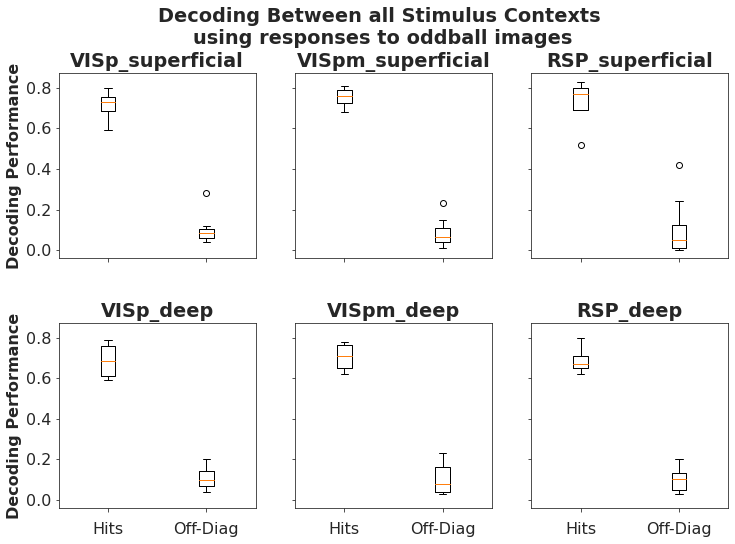

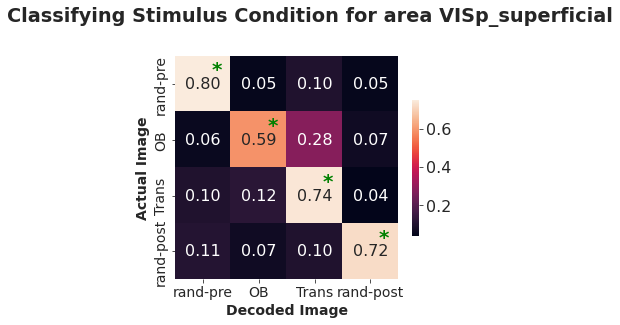

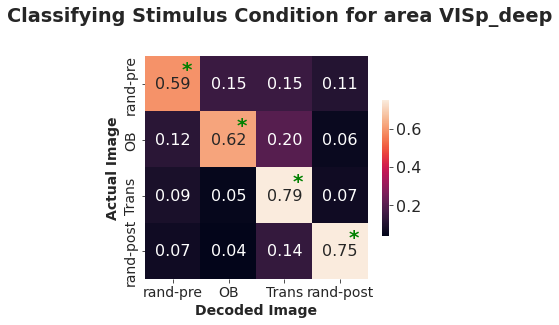

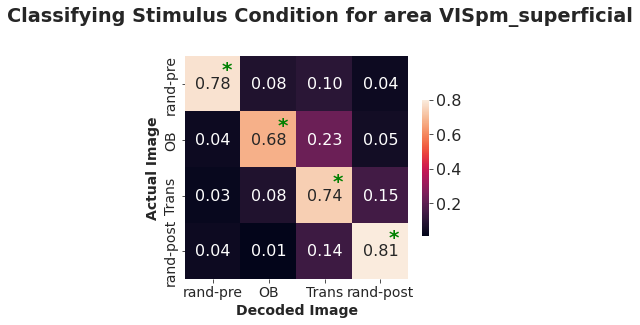

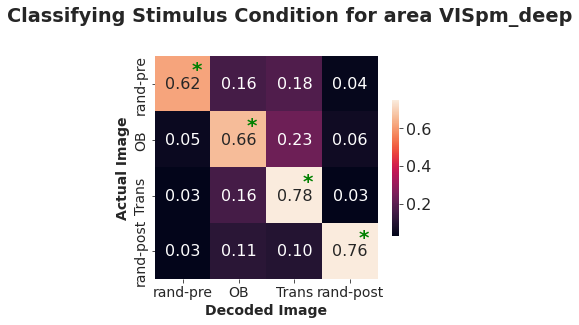

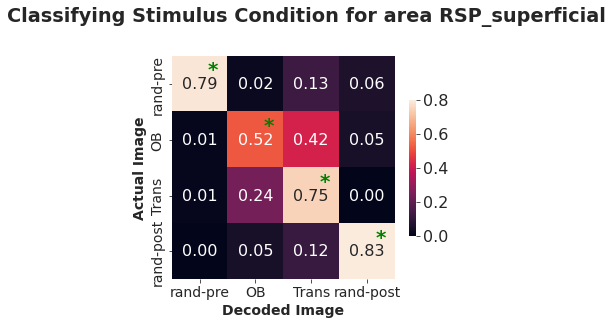

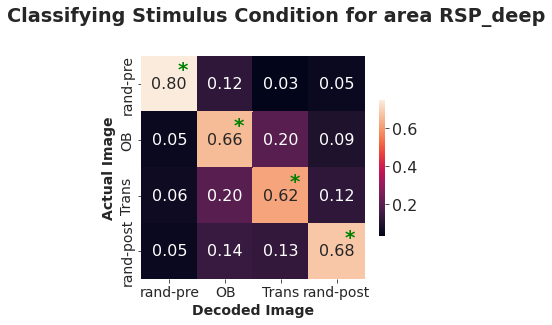

In [210]:
#Let's decode stimulus blocks from each other based on responses to oddball images

method='kfold'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))


reduce_dim = True
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

    
fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
for ii, area in enumerate(areanames):
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get data for this area
        X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pseudopop_responses[area][0].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='X')
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X',trial_indy=slice(740,860))
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')
        X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pseudopop_responses[area][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='X')
        
        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        
    
        indy_list = []; indy_list2 = []; indy_list3 = []
        for iImg, img_ID in enumerate(oddball_ids):
            tmp = np.where(Y_randctrl_pre == img_ID)[0]
            np.random.shuffle(tmp)
            indy_list.append(tmp[:10])
            
            tmp = np.where(Y_randctrl_post == img_ID)[0]
            np.random.shuffle(tmp)
            indy_list2.append(tmp[:10])
            
            tmp = np.where(Y_transctrl == img_ID)[0]
            np.random.shuffle(tmp)
            indy_list3.append(tmp[:10])
            
        indy_randctrlpre = np.concatenate(indy_list)
        indy_randctrlpost = np.concatenate(indy_list2)
        indy_transctrl = np.concatenate(indy_list3)

        #Construct X and Y from both blocks
        X = np.vstack((X_randctrl_pre[indy_randctrlpre,:],X_oddball,X_transctrl[indy_transctrl,:],X_randctrl_post[indy_randctrlpost,:]))
        Y = np.hstack([np.repeat(i,100) for i in range(nClasses)])
        
        Y_sort = np.concatenate((['{}_0'.format(int(Y_randctrl_pre[ii])) for ii in indy_randctrlpre],['{}_1'.format(int(yy)) for yy in Y_oddball],['{}_2'.format(int(Y_transctrl[ii])) for ii in indy_transctrl],['{}_3'.format(int(Y_randctrl_post[ii])) for ii in indy_randctrlpost]))

        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X)
            nComponents_pca = X_pca.shape[-1]
            print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
        else:
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,parallel=False)

        fpath = os.path.join(SaveDir,'StimulusBlocks_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['rand-pre','OB', 'Trans','rand-post'])
        plt.suptitle('Classifying Stimulus Condition for area {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'StimulusBlocks_usingoddballs_{}_{}_{}.png'.format(locstr,method,classifier)))
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.diag(confusion_mat)
        offdiag_hits = confusion_mat[off_diagonal_indy] 
        
        axes2[jj,ii].set_title(locstr)
        axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
        if jj == 1:
            axes2[jj,ii].set_xticks([1,2])
            axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            axes2[jj,ii].set_ylabel('Decoding Performance')
            
#         plt.show()
#         pdb.set_trace()
            
fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to oddball images',y=0.995)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_usingoddballs{}_{}.png'.format(method,classifier)))

In [206]:
np.unique(Y_sort,return_counts=True)

(array(['103_0', '103_1', '103_2', '103_3', '110_0', '110_1', '110_2',
        '110_3', '111_0', '111_1', '111_2', '111_3', '112_0', '112_1',
        '112_2', '112_3', '17_0', '17_1', '17_2', '17_3', '22_0', '22_1',
        '22_2', '22_3', '51_0', '51_1', '51_2', '51_3', '6_0', '6_1',
        '6_2', '6_3', '71_0', '71_1', '71_2', '71_3', '89_0', '89_1',
        '89_2', '89_3'], dtype='<U5'),
 array([10, 10, 10, 10, 13, 10, 10, 10,  7, 10, 10, 10, 11, 10, 10, 10,  3,
        10, 10, 10, 11, 10, 10, 10, 11, 10, 10, 10,  9, 10, 10, 10, 13, 10,
        10, 10, 12, 10, 10, 10]))

In [197]:
fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to main-sequence images',y=0.995)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_{}_{}.png'.format(method,classifier)))

In [199]:
Y_sort = np.concatenate((['{}_0'.format(int(yy)) for yy in Y_oddball],['{}_1'.format(int(Y_randctrl[i])) for i in indy_randctrl]))

Ttest_indResult(statistic=14.435857627570785, pvalue=1.7013231868980983e-21)

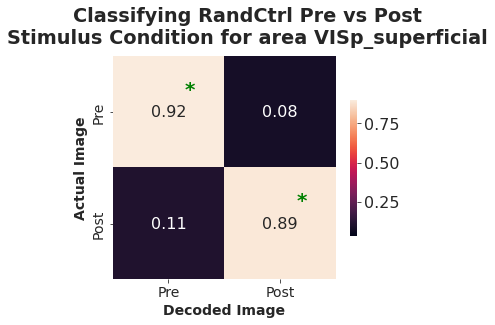

> <ipython-input-218-1f6fefa04c60>(22)<module>()
     20 
     21 #Loop over depth as well
---> 22 for depthstr in ['superficial','deep']:
     23     locstr = '{}_{}'.format(area,depthstr)
     24     cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values



ipdb>  q


BdbQuit: 

In [218]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context

method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

# for area in areanames:
area = 'VISp'
cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values

#Loop over depth as well
for depthstr in ['superficial','deep']:
    locstr = '{}_{}'.format(area,depthstr)
    cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
    cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

#         fig, axes = plt.subplots(1,2,figsize=(10,5))
    #Get data for this area
    X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pseudopop_responses[area][0].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
    X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pseudopop_responses[area][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')

    confusion_mat = np.zeros((4,nClasses,nClasses))
    confusion_shf = np.zeros((4,nClasses,nClasses))
    confusion_z = np.zeros((4,nClasses,nClasses))

    nNeurons = X_randctrl_pre.shape[-1]
    for iImg, img_ID in enumerate(mainseq_ids):
        #Get stimulus presentation IDs for this particular image from both blocks
        indy_pre = np.where(Y_randctrl_pre == img_ID)[0]
        indy_post = np.where(Y_randctrl_post == img_ID)[0]

        #Construct X and Y from both blocks
        X = np.vstack((X_randctrl_pre[indy_pre,:],X_randctrl_post[indy_post,:]))
        Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))

        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X)
            nComponents_pca = X_pca.shape[-1]
            print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

            #Perform cross-validated decoding analysis
            confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
        else:
            confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)

#                 pdb.set_trace()
    fpath = os.path.join(SaveDir,'RandomizedCtrl_PreVsPost_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    #Plot shuffle distributions
    dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),class_labels=['Pre','Post'])

    plt.suptitle('Classifying RandCtrl Pre vs Post\nStimulus Condition for area {}'.format(locstr),y=0.95)
    plt.savefig(os.path.join(PlotDir,'RandomizedCtrl_PreVsPost_avg-over-ms_{}_{}_{}.png'.format(locstr,method,classifier)))

    plt.show()
    pdb.set_trace()

In [119]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
classifier = 'LDA'
method='L1O'

nClasses = 2

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
    
        #Get trials where MS images were presented from the randomized_ctrl block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')

        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))

        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        nNeurons = X_randctrl.shape[-1]
        for iImg, img_ID in enumerate(mainseq_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_transctrl = np.where(Y_transctrl == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:]))
            Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))
            
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]
                print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))
                
                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)
            
            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)
                
        fpath = os.path.join(SaveDir,'TransitionCtrlVsOddballBlocks_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        title = 'Classifying stimulus condition: Sequence vs Transition Control for {}'.format(locstr)
        dc.plot_confusion_matrices(confusion_mat, confusion_z, plot_titles=['A from (D,A)','B from (A,B)','C from (B,C)','D from (C,D)'],class_labels=['Sequence','Trans-Control'],title=title)
        plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_{}_{}_{}.png'.format(locstr,method,classifier)))

(array([  6.,  17.,  22.,  51.,  71.,  89., 103., 110., 111., 112.]),
 array([30, 30, 30, 30, 30, 30, 30, 30, 30, 30]))

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context

method='L1O'
PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)
            #Get data for this area
            X_randctrl_all = randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth]
            X_oddball_all = oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth]

            #Get trials where MS images were presented from the randomized_ctrl block
            X_randctrl, Y_randctrl, _ = dc.match_trials(X_randctrl_all, stimulus_df, block=block_str, trial_type='ABCD')

            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(X_oddball_all, stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))
            pdb.set_trace()
            confusion_mat = np.zeros((4,nClasses,nClasses))
            confusion_shf = np.zeros((4,nClasses,nClasses))
            confusion_z = np.zeros((4,nClasses,nClasses))

            nNeurons = X_randctrl.shape[-1]
            for iImg, img_ID in enumerate(mainseq_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_oddball = np.where(Y_oddball == img_ID)[0]
                indy_randctrl = np.where(Y_randctrl == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_oddball[indy_oddball,:],X_randctrl[indy_randctrl,:]))
                Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))
                
                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))
            
                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],nKfold=5,classifier=classifier,method=method,plot_shuffle=False,parallel=False)

#                 pdb.set_trace()
            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_MSimgs_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            title = 'Sequence vs RandCtrl-{}'.format(pstr)
            dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=axes[ii],class_labels=['Sequence','Rand-Ctrl'],title=title)
        plt.suptitle('Classifying Stimulus Condition for area {}'.format(locstr),y=0.925)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsOddballBlocks_avg-over-ms_{}_{}_{}.png'.format(locstr,method,classifier)))

## Let's see if we can decode the transition control vs oddball context 
using trials where the MS images were presented

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
classifier = 'LDA'
method='L1O'

nClasses = 2

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
    
        #Get trials where MS images were presented from the randomized_ctrl block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')

        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))

        confusion_mat = np.zeros((4,nClasses,nClasses))
        confusion_shf = np.zeros((4,nClasses,nClasses))
        confusion_z = np.zeros((4,nClasses,nClasses))

        nNeurons = X_randctrl.shape[-1]
        for iImg, img_ID in enumerate(mainseq_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_transctrl = np.where(Y_transctrl == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:]))
            Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))
            
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]
                print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))
                
                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)
            
            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)
                
        fpath = os.path.join(SaveDir,'TransitionCtrlVsOddballBlocks_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        title = 'Classifying stimulus condition: Sequence vs Transition Control for {}'.format(locstr)
        dc.plot_confusion_matrices(confusion_mat, confusion_z, plot_titles=['A from (D,A)','B from (A,B)','C from (B,C)','D from (C,D)'],class_labels=['Sequence','Trans-Control'],title=title)
        plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_{}_{}_{}.png'.format(locstr,method,classifier)))

In [120]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
classifier = 'LDA'
method='L1O'

nClasses = 2

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fpath = os.path.join(SaveDir,'TransitionCtrlVsOddballBlocks_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))            
        with h5py.File(fpath,'r') as h5results:
            confusion_mat = np.array(h5results['confusion_mat'])
            confusion_shf = np.array(h5results['confusion_shf'])
            confusion_z = np.array(h5results['confusion_z'])
            
        pdb.set_trace()

        
    

> <ipython-input-120-a19b852689c2>(21)<module>()
     19 
     20     #Loop over depth as well
---> 21     for depthstr in ['superficial','deep']:
     22         locstr = '{}_{}'.format(area,depthstr)
     23         cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values



ipdb>  confusion_mat.shape


(4, 2, 2)


ipdb>  np.diag(confusion_mat)


*** ValueError: Input must be 1- or 2-d.


ipdb>  main_diag = [np.diag(confusion_mat[ii]) for ii in range(confusion_mat.shape[0])]
ipdb>  main_diag


[array([1. , 0.9]), array([1.        , 0.96666667]), array([1., 1.]), array([1. , 0.9])]


ipdb>  main_diag = np.concatenate([np.diag(confusion_mat[ii]) for ii in range(confusion_mat.shape[0])])
ipdb>  main_diag


array([1.        , 0.9       , 1.        , 0.96666667, 1.        ,
       1.        , 1.        , 0.9       ])


ipdb>  q


BdbQuit: 

In [87]:
st.norm.sf(confusion_z[-1])

array([[0.08210522, 0.91789478],
       [0.9633145 , 0.0366855 ]])

## What if we compare transition control with randomized control?
Give we can decode the oddball context from both the randomized control and transition control, we might expect the 2 to be indistiguishable...
But that's not what we find!

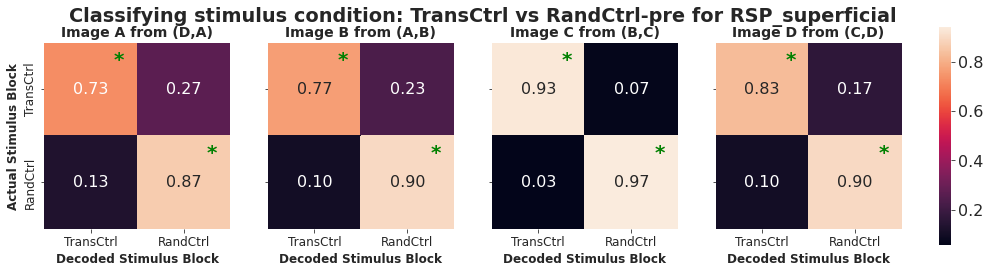

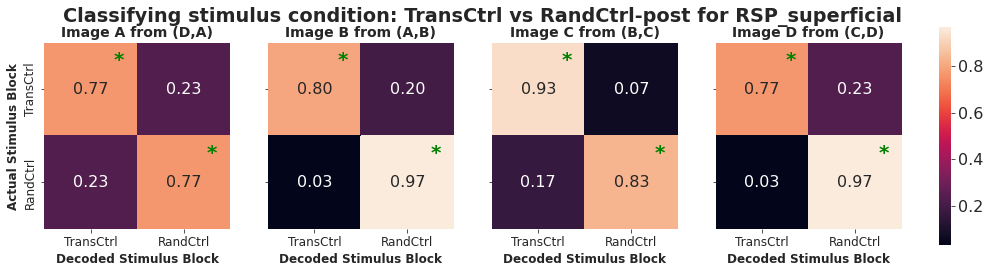

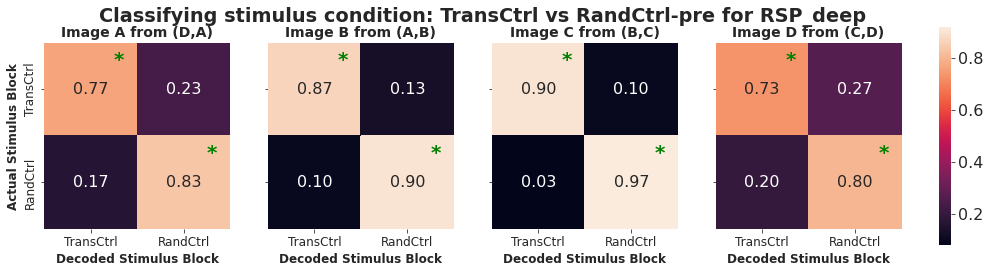

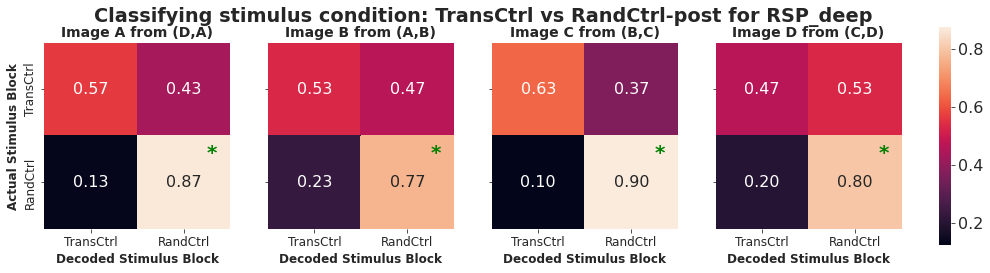

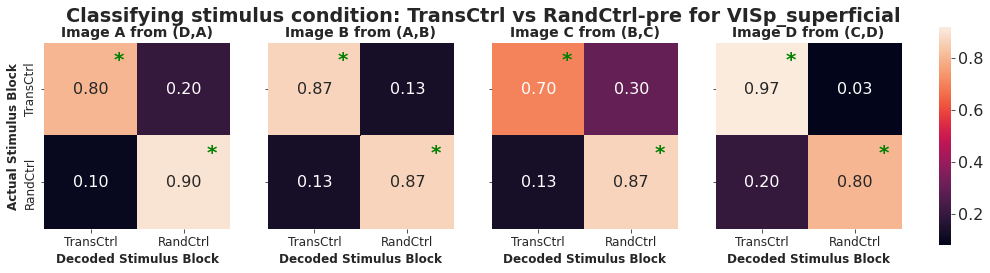

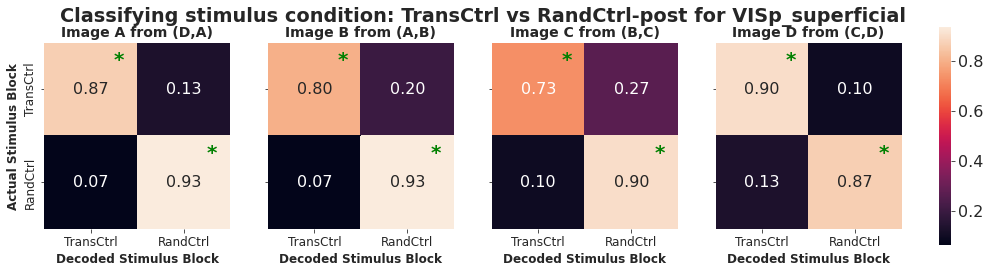

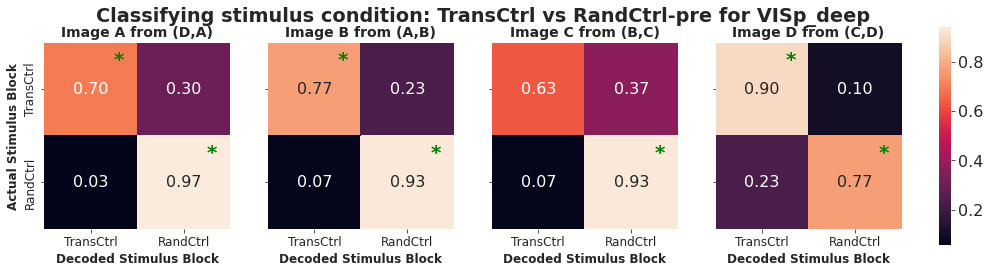

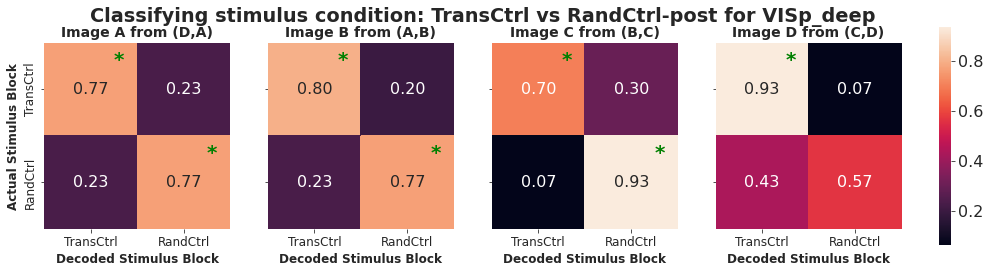

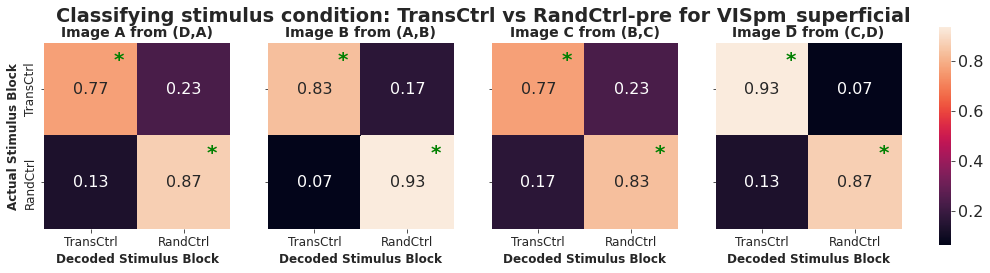

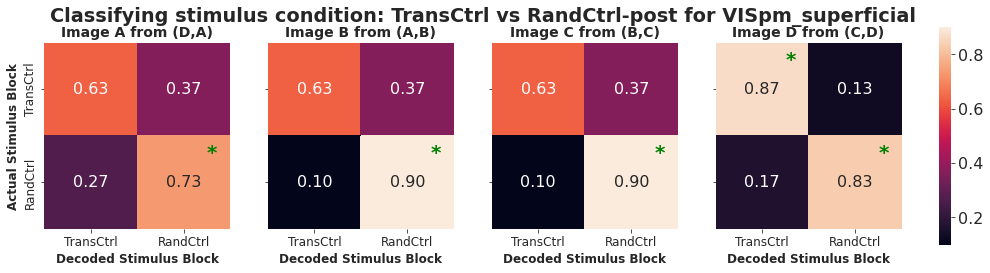

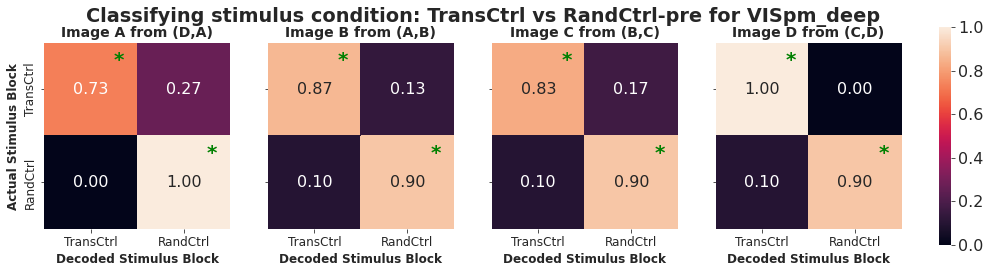

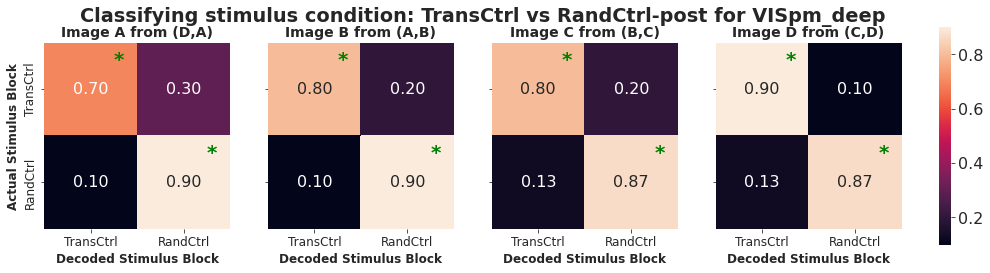

In [94]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
classifier = 'LDA'
method='L1O'

nClasses = 2

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    cell_ids = transctrl_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)

            #Get trials where MS images were presented from the randomized_ccontrol block
            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='ABCD')

            #Get trials where MS images were presented from the transition_control block
            X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')

            confusion_mat = np.zeros((4,nClasses,nClasses))
            confusion_shf = np.zeros((4,nClasses,nClasses))
            confusion_z = np.zeros((4,nClasses,nClasses))

            nNeurons = X_randctrl.shape[-1]
            for iImg, img_ID in enumerate(mainseq_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_transctrl = np.where(Y_transctrl == img_ID)[0]
                indy_randctrl = np.where(Y_randctrl == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_transctrl[indy_transctrl,:],X_randctrl[indy_randctrl,:]))
                Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))
                
                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    #                     print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsTransitionCtrl_MSimgs_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            title = 'Classifying stimulus condition: TransCtrl vs RandCtrl-{} for {}'.format(pstr,locstr)
            dc.plot_confusion_matrices(confusion_mat, confusion_z, plot_titles=['A from (D,A)','B from (A,B)','C from (B,C)','D from (C,D)'],class_labels=['TransCtrl','RandCtrl'],title=title)
            plt.savefig(os.path.join(PlotDir,'RandomizedCtrl-{}VsTransitionCtrl_{}_{}.png'.format(pstr,locstr,method,classifier)))


## Let's use the oddball images to see if we decode context
Again, let's start with oddball vs randomized control

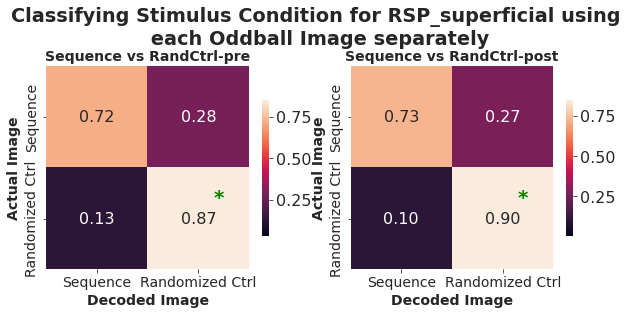

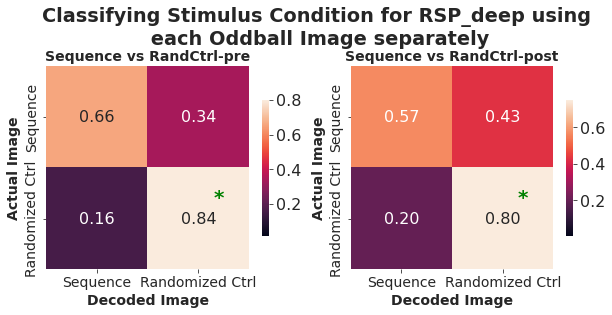

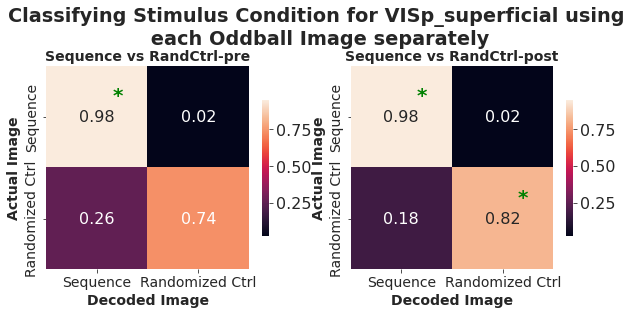

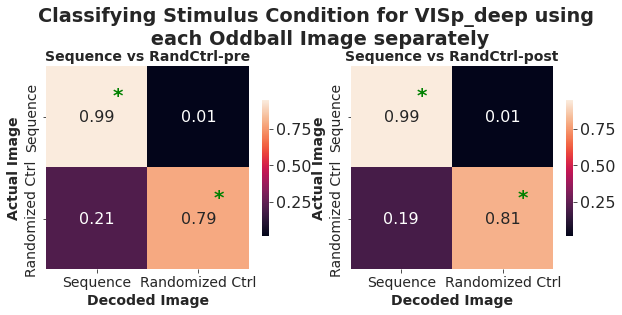

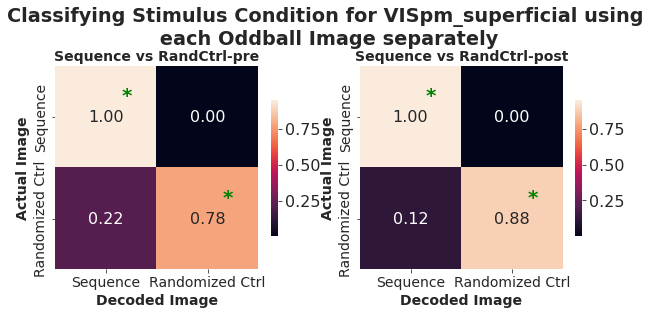

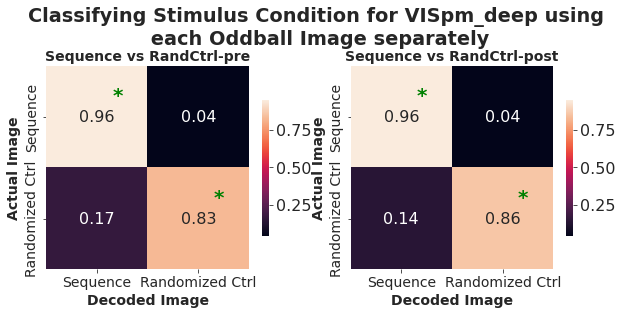

In [39]:
# Let's decode stimulus context per oddball image; i.e. gather trials where an oddball image was presented from both conditions and decode stimulus context that way;
# We will have 10 confusion matrices which we will average over
# The problem with this is that each oddball is only presented 10 times in the oddball block, hence why we are doing leave-1-out x-validation
classifier = 'LDA'
method='L1O'

nClasses = 2

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)

            #Get trials where MS images were presented from the randomized_ctrl block
            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')

            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X',trial_indy=slice(740,860))

            confusion_mat = np.zeros((len(oddball_ids),2,2))
            confusion_shf = np.zeros((len(oddball_ids),2,2))
            confusion_z = np.zeros((len(oddball_ids),2,2))

            for iImg, img_ID in enumerate(oddball_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_oddball = np.where(Y_oddball == img_ID)[0]
                indy_randctrl = np.where(Y_randctrl == img_ID)[0]
                np.random.shuffle(indy_randctrl)

                #Construct X and Y from both blocks
                X = np.vstack((X_oddball[indy_oddball,:],X_randctrl[indy_randctrl[:10],:]))
                Y = np.hstack((np.repeat(0,10),np.repeat(1,10)))

                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    #                     print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_OBimgs_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            title = 'Sequence vs RandCtrl-{}'.format(pstr)
            dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=axes[ii],class_labels=['Sequence','Randomized Ctrl'],title=title)
        plt.suptitle('Classifying Stimulus Condition for {} using\n each Oddball Image separately'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsOddballBlocks_avg-over-oddballs_{}_{}_{}.png'.format(locstr,method,classifier)))

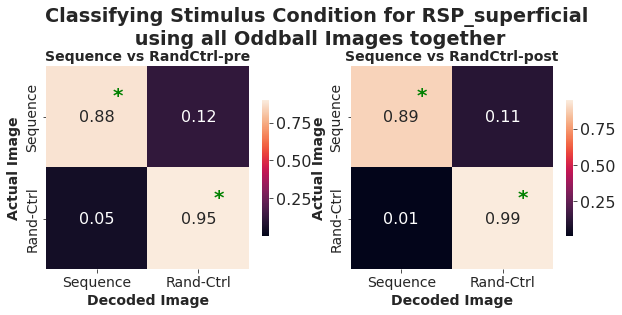

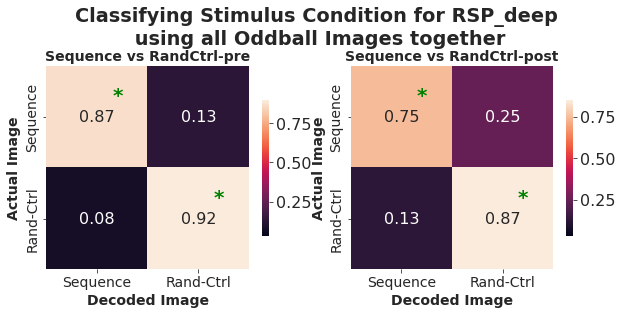

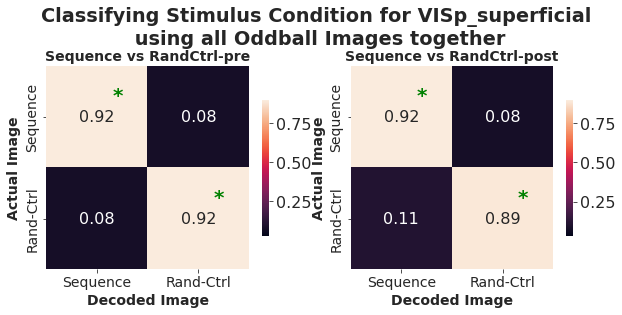

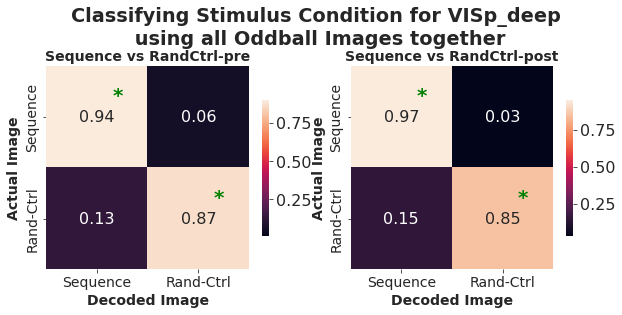

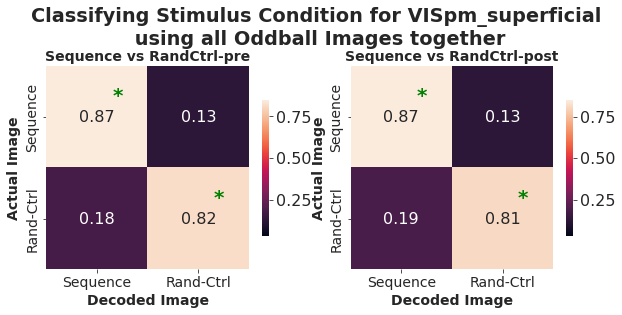

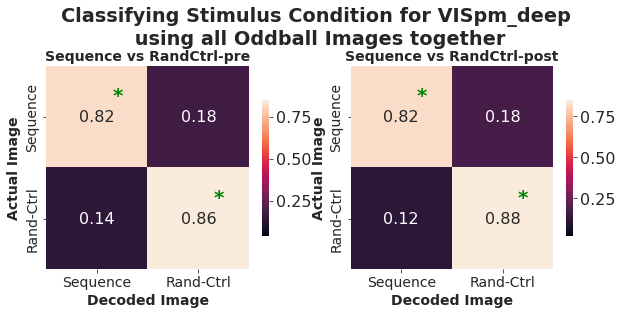

In [44]:
#Let's do the same thing, but combine all the trials where an oddball was presented and use those to decode stimulus context;
#This way we have more trials for each stimulus context
method='kfold'
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)

            #Get trials where MS images were presented from the randomized_ctrl block
            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')

            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')

            indy_list = []
            for iImg, img_ID in enumerate(oddball_ids):
                tmp = np.where(Y_randctrl == img_ID)[0]
                np.random.shuffle(tmp)
                indy_list.append(tmp[:10])

            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_randctrl = np.concatenate(indy_list)

            #Construct X and Y from both blocks
            X = np.vstack((X_oddball,X_randctrl[indy_randctrl,:]))
            Y = np.hstack((np.repeat(0,len(Y_oddball)),np.repeat(1,len(indy_randctrl))))

            #Create this vector so that the cross validation conserves the proportion of trials for each oddball image in the training and test sets
            Y_sort = np.concatenate((['{}_0'.format(int(yy)) for yy in Y_oddball],['{}_1'.format(int(Y_randctrl[i])) for i in indy_randctrl]))
#             pdb.set_trace()
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)

            else:
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)
                    

            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_OBimgTogether_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            title = 'Sequence vs RandCtrl-{}'.format(pstr)
            dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['Sequence','Rand-Ctrl'],title=title)
        plt.suptitle('Classifying Stimulus Condition for {}\n using all Oddball Images together'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsOddballBlocks_all-oddballs_{}_{}_{}.png'.format(locstr,method,classifier)))

## What about oddball vs transition control?
again using the oddball images separately, then averaging over them

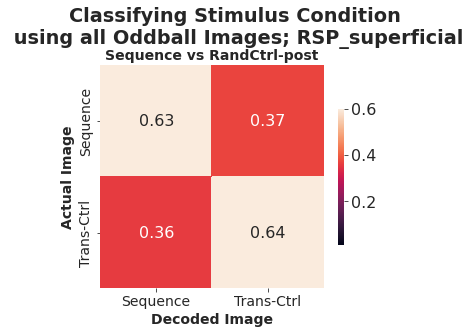

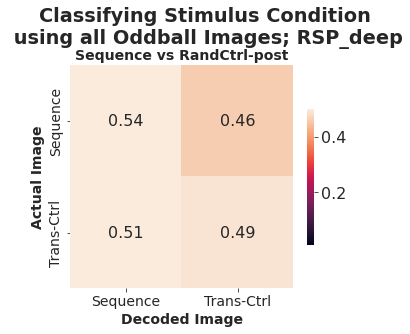

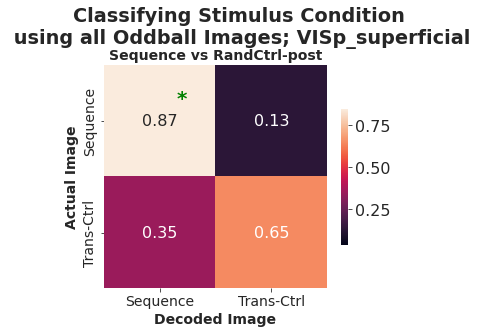

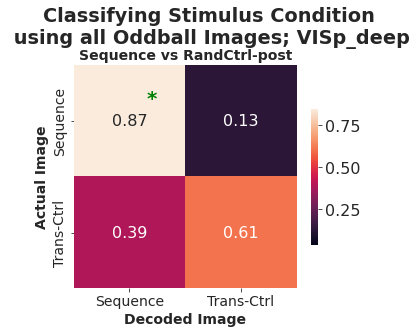

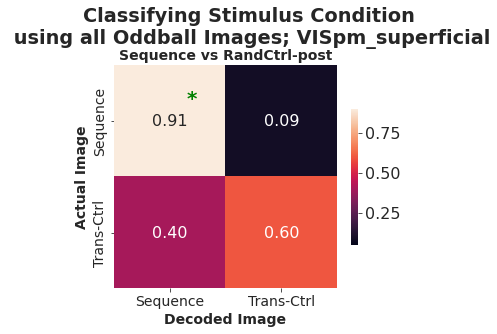

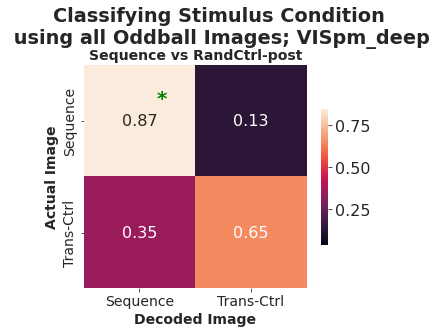

In [48]:
classifier = 'nearest_neighbor'
method='L1O'
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where odbball images were presented from the transition_control block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

        #Get trials where odbball images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')

        confusion_mat = np.zeros((len(oddball_ids),2,2))
        confusion_shf = np.zeros((len(oddball_ids),2,2))
        confusion_z = np.zeros((len(oddball_ids),2,2))

        for iImg, img_ID in enumerate(oddball_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_oddball = np.where(Y_oddball == img_ID)[0]
            indy_transctrl = np.where(Y_transctrl == img_ID)[0]
            np.random.shuffle(indy_transctrl)

            #Construct X and Y from both blocks
            X = np.vstack((X_oddball[indy_oddball,:],X_transctrl[indy_transctrl[:10],:]))
            Y = np.hstack((np.repeat(0,10),np.repeat(1,10)))

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsOddballBlocks_OBimgs_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),class_labels=['Sequence','Trans-Ctrl'],title=title)
        plt.suptitle('Classifying Stimulus Condition\n using all Oddball Images; {}'.format(locstr),y=0.975)
        plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_avg-over-oddballs_{}_{}_{}.png'.format(locstr,method,classifier)))

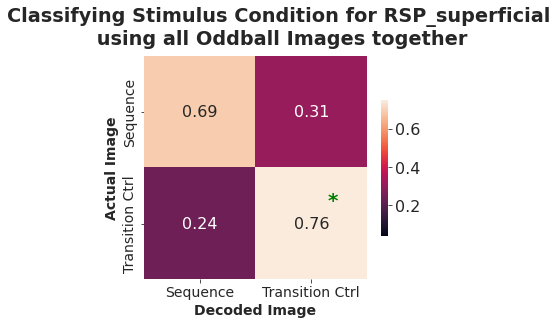

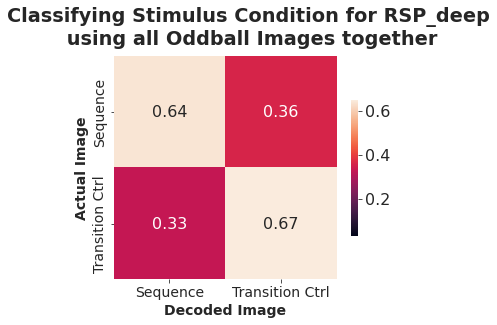

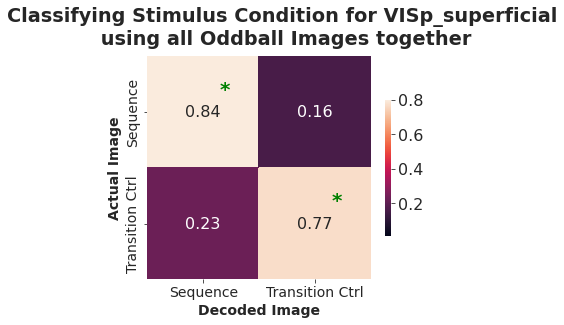

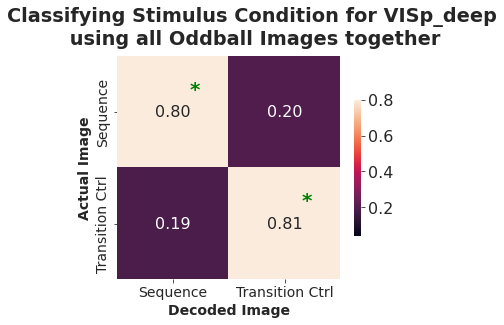

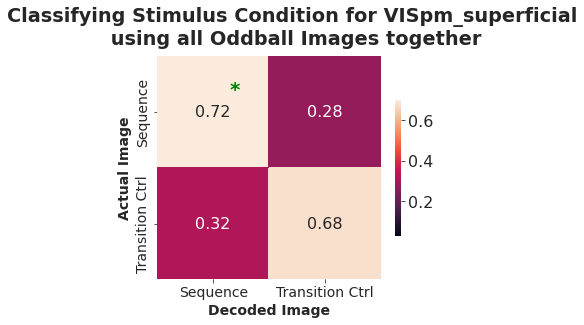

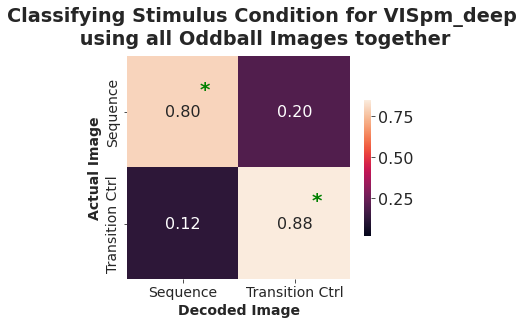

In [50]:
#For completeness sakes, let's do the same thing, but combine all the trials where an oddball was presented and use those to decode stimulus context;
#This way we have more trials for each stimulus context
classifier = 'SVM'
method='kfold'
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where odbball images were presented from the transition_control block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')

        #Since the transition control block has more than 10 trials per oddball image, we have to take 10 randomly
        indy_list = []
        for img_ID in oddball_ids:
            tmp = np.where(Y_transctrl == img_ID)[0]
            np.random.shuffle(tmp)
            indy_list.append(tmp[:10])

        indy_transctrl = np.concatenate(indy_list)

        #Construct X and Y from both blocks
        X = np.vstack((X_oddball,X_transctrl[indy_transctrl,:]))
        Y = np.hstack((np.repeat(0,len(Y_oddball)),np.repeat(1,len(indy_transctrl))))

        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)

        else:
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)
               

        #Perform cross-validated decoding analysis
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'TransitionCtrl-{}VsOddballBlocks_OBimgTogether_{}_{}.mat'.format(pstr,locstr,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['Sequence','Transition Ctrl'])
        plt.suptitle('Classifying Stimulus Condition for {}\n using all Oddball Images together'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_all-oddballs_{}_{}.png'.format(locstr,classifier)))

## What about transition control vs randomized control?
using the oddball images 

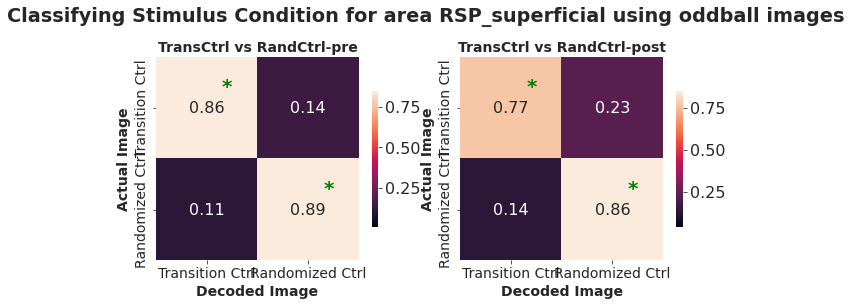

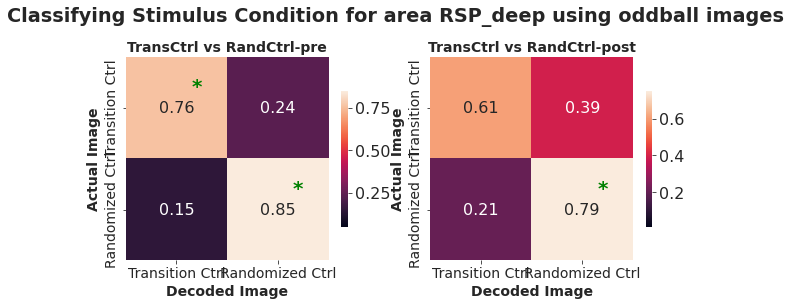

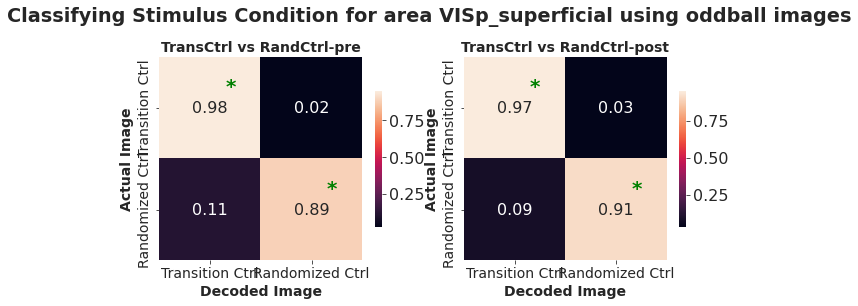

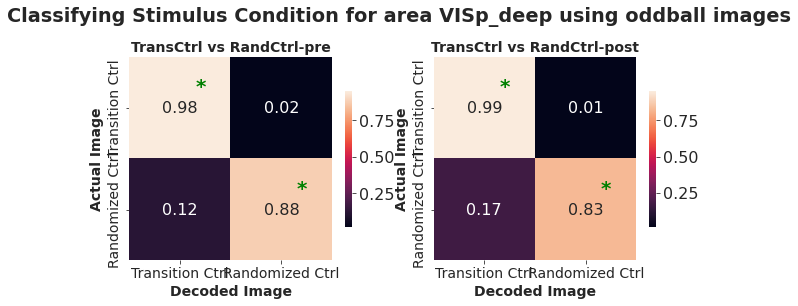

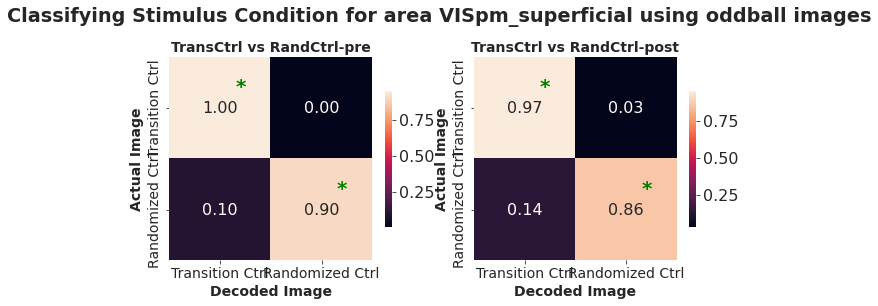

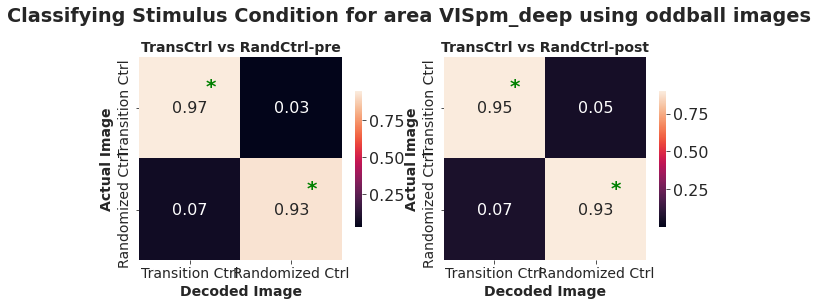

In [53]:
classifier = 'nearest_neighbor'
method='L1O'
reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)

            #Get trials where MS images were presented from the randomized_ccontrol block
            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')

            #Get trials where MS images were presented from the transition_control block
            X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

            confusion_mat = np.zeros((len(oddball_ids),2,2))
            confusion_shf = np.zeros((len(oddball_ids),2,2))
            confusion_z = np.zeros((len(oddball_ids),2,2))

            for iImg, img_ID in enumerate(oddball_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_transctrl = np.where(Y_transctrl == img_ID)[0]
                indy_randctrl = np.where(Y_randctrl == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_transctrl[indy_transctrl,:],X_randctrl[indy_randctrl,:]))
                Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))

                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]

                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

            fpath = os.path.join(SaveDir,'RandomizedCtrl-{}VsTransitionCtrl_MSimgs_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            title = 'TransCtrl vs RandCtrl-{}'.format(pstr)
            dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),ax=axes[ii],class_labels=['Transition Ctrl','Randomized Ctrl'],title=title)

        plt.suptitle('Classifying Stimulus Condition for area {} using oddball images'.format(locstr),y=0.925)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrlVsTransitionCtrl_avg-over-oddballs_{}_{}_{}.png'.format(locstr,method,classifier)))

## Let's try to decode trials in which image A followed image D vs an oddball
i.e. DA vs XA transitions in the transition control

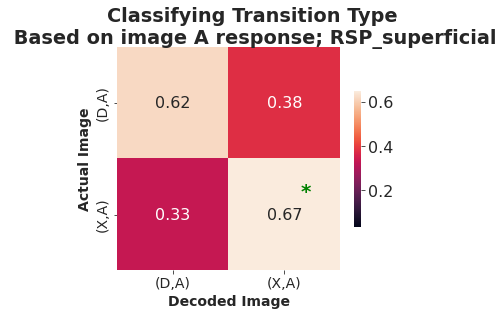

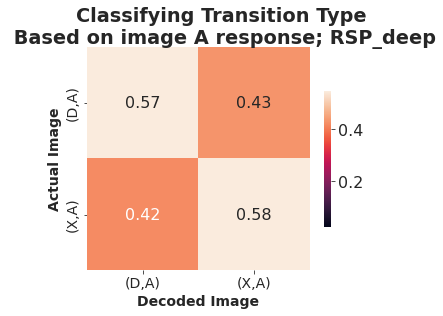

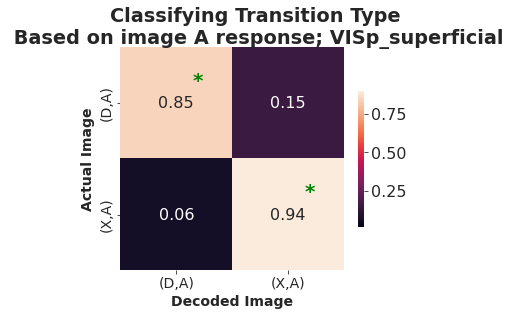

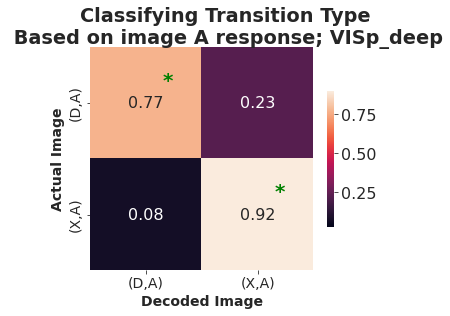

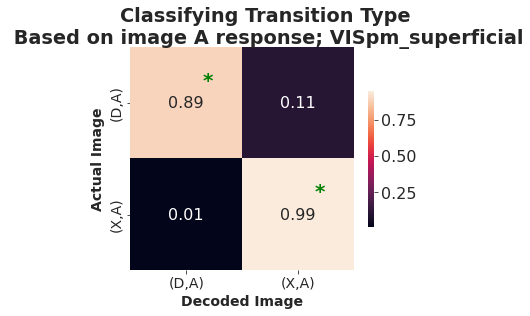

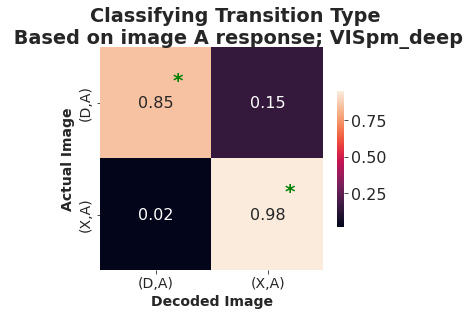

In [55]:
#In the transition control, there are 30 trials per transition type. so, there are 30 trials where DA are presented in series and 30 trials where DX are presented per oddball
#So, given the # of trials per transition type, I created a decoder for each XA type, keeping the DA trials the same
method='L1O'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')


nClasses = 2
for area in areanames:
    cell_ids = transctrl_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where A images were presented from the transition_control block
        X_transctrl, Y_transctrl, Y_sort = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='DAXA')

        confusion_mat = np.zeros((len(oddball_ids),2,2))
        confusion_shf = np.zeros((len(oddball_ids),2,2))
        confusion_z = np.zeros((len(oddball_ids),2,2))

        for iImg, img_ID in enumerate(oddball_ids):
            #Get stimulus presentation IDs for this particular image from both blocks
            indy_DA = np.where(Y_sort == mainseq_ids[0])[0]
            indy_XA = np.where(Y_sort == img_ID)[0]

            #Construct X and Y from both blocks
            X = np.vstack((X_transctrl[indy_DA,:],X_transctrl[indy_XA,:]))
            Y = np.hstack((np.repeat(0,len(indy_DA)),np.repeat(1,len(indy_XA))))

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

            else:
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'DAvsXA_TransCtrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(np.mean(confusion_mat,axis=0),np.mean(confusion_z,axis=0),class_labels=['(D,A)','(X,A)'])

        plt.suptitle('Classifying Transition Type\n Based on image A response; {}'.format(locstr),y=0.925)
        plt.savefig(os.path.join(PlotDir,'DAvsXA_TransCtrl-block_{}_{}_{}.png'.format(locstr,method,classifier)))

## What about in the oddball block: (X,A) vs (D,A)

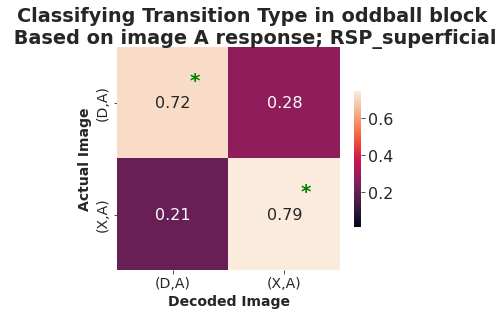

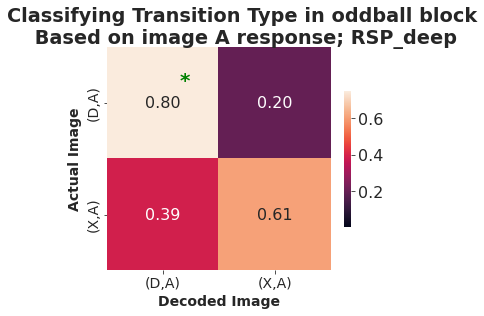

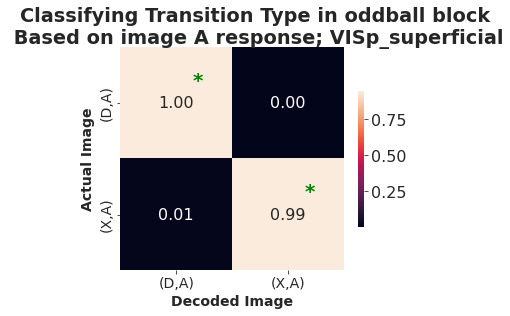

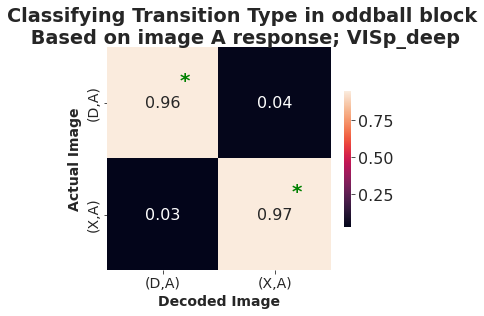

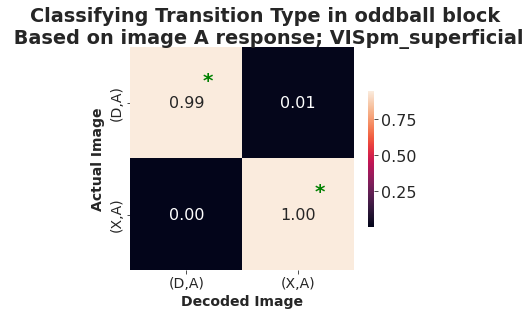

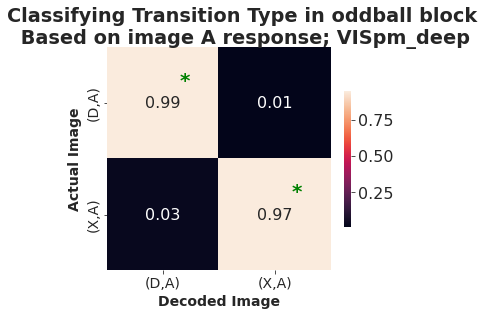

In [58]:
#In the transition control, there are 30 trials per transition type. so, there are 30 trials where DA are presented in series and 30 trials where DX are presented per oddball
#So, given the # of trials per transition type, I created a decoder for each XA type, keeping the DA trials the same
method='kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

nClasses = 2
for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where A images were presented from the transition_control block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='DAXA')

#         #Perform cross-validated decoding analysis
#         confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=[0,1],classifier=classifier,method=method)
        
        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_oddball)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,clabels=[0,1],classifier=classifier,method=method)

        else:
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=[0,1],classifier=classifier,method=method)
                
        fpath = os.path.join(SaveDir,'DAvsXA_Oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['(D,A)','(X,A)'])
        plt.suptitle('Classifying Transition Type in oddball block\n Based on image A response; {}'.format(locstr),y=0.925)
        # plt.show()
        # pdb.set_trace()
        plt.savefig(os.path.join(PlotDir,'DAvsXA_Oddball-block_{}_{}_{}.png'.format(locstr,method,classifier)))

## Image Identity
Let's see if we can decode image identity in the randomized blocks using the pseudopopulation 

In [66]:
np.unique(Y_transctrl,return_counts=True)

(array([13., 26., 68., 78.]), array([30, 30, 30, 30]))

In [ ]:
classifier = 'nearest_neighbor'
method='kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))
    
for ii, pstr in enumerate(['pre','post']): 

    fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
    for area in areanames:
    # area = 'VISp'
        cell_ids = randctrl_pseudopop_responses[area][0].coords['cell_specimen_id'].values

    #Loop over depth as well
    
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

#         fig, axes = plt.subplots(1,2,figsize=(10,5))
        for depthstr in ['superficial','deep']:
            block_str = 'randomized_control_{}'.format(pstr)
            X_randctrl_all = randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth]

            #Get trials where MS images were presented from the randomized_ctrl block
            X_randctrl, Y_randctrl, _ = dc.match_trials(X_randctrl_all, stimulus_df, block=block_str, trial_type='ABCD')
            
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X_randctrl)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_randctrl,clabels=mainseq_ids,classifier=classifier,method=method)

            else:
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_randctrl,Y_randctrl,clabels=mainseq_ids,classifier=classifier,method=method)
            
#             fpath = os.path.join(SaveDir,'mainseq_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
#             with h5py.File(fpath,'w') as h5file:
#                 h5file.create_dataset('confusion_mat',data=confusion_mat)
#                 h5file.create_dataset('confusion_shf',data=confusion_shf)
#                 h5file.create_dataset('confusion_z',data=confusion_z)
#                 h5file.create_dataset('area',data=area)
#                 h5file.create_dataset('classifier',data=classifier)
#                 h5file.create_dataset('method',data=method)

#             dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],clims=[0.1,0.4])

#         plt.suptitle('Classifying MS images for {}, {} classifer'.format(locstr,classifier),y=0.925,fontsize=14)
#         plt.savefig(os.path.join(PlotDir,'mainseq_decoding_randctrl-blocks_{}_{}.png'.format(locstr,classifier)))
        
             #Sparate diagonal and off-diagonal performance
            diag_hits = np.diag(confusion_mat)
            offdiag_hits = confusion_mat[off_diagonal_indy]

            axes2[jj,ii].set_title(locstr)
            axes2[jj,ii].boxplot([diag_hits,offdiag_hits])
            if jj == 1:
                axes2[jj,ii].set_xticks([1,2])
                axes2[jj,ii].set_xticklabels(['Hits','Off-Diag'])
            if ii == 0:
                axes2[jj,ii].set_ylabel('Decoding Performance')
            
    fig2.suptitle('Classifying MS images for {}, {} classifer'.format(locstr,classifier),y=0.995)
    fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_randctrl-blocks_{}_{}.png'.format(method,classifier)))


## What if we combine randomized control pre and post?

In [ ]:
classifier = 'nearest_neighbor'

for ii,area in enumerate(areanames):
     cell_ids = randctrl_pseudopop_responses[area][0].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where MS images were presented from the randomized_ctrl block
        X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pseudopop_responses[area][0].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
        X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pseudopop_responses[area][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')

        X_combined = np.vstack((X_randctrl_pre,X_randctrl_post))
        Y_combined = np.hstack((Y_randctrl_pre,Y_randctrl_post))

        #Use pseudopopulation vectors for decoding
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_combined,Y_combined,method='kfold',nKfold=5,classifier=classifier,plot_shuffle=True,clabels=mainseq_ids)

        fpath = os.path.join(SaveDir,'X-img_decoding_randomized-ctrl-block_{}_{}.mat'.format(locstr,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=title_str,annot=True,clims=[0.05,0.45])
    plt.suptitle('Classifying MS Images in randomized control block, {} classifier'.format(classifier))
    plt.savefig(os.path.join(PlotDir,'mainseq_decoding_randctrl-combined_{}_{}.png'.format(locstr,classifier)))

## Let's see if we can decode image identity in the transition control block
using the second images of the (D,A),(A,B),(B,C),(C,D) transitions 

In [219]:
areanames = ['VISp', 'VISpm', 'RSP']

['VISp', 'VISpm', 'RSP']

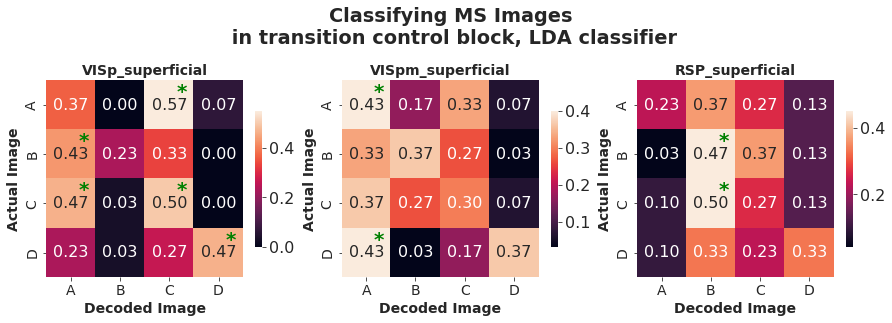

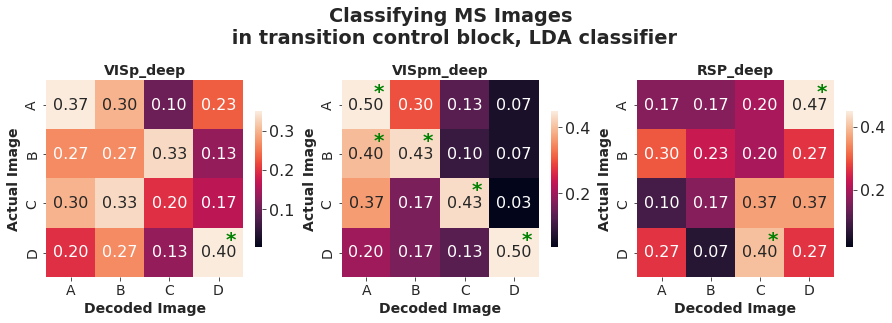

In [220]:
method='L1O'
reduce_dim=True
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
#Loop over depth as well
for depthstr in ['superficial','deep']:

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = transctrl_pseudopop_responses[area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where MS images were presented from the transition control block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')

        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_transctrl)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_transctrl,clabels=mainseq_ids,classifier=classifier,method=method)

        else:
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_transctrl,Y_transctrl,clabels=mainseq_ids,classifier=classifier,method=method)

        fpath = os.path.join(SaveDir,'mainseq_decoding_transition-ctrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=locstr,annot=True)
    plt.suptitle('Classifying MS Images\n in transition control block, {} classifier'.format(classifier))
    plt.savefig(os.path.join(PlotDir,'mainseq_decoding_transition-ctrl-block_{}-areas_{}_{}.png'.format(depthstr,method,classifier)))

In [236]:
6400/200

32.0

## Can we decode image identity in the oddball block?
Let's use the first 240 trials, then 240 trials in the middle, then the last 240 trials

start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}
start-{:03d}


In [275]:
jj = 0
tmp_list1 = []; tmp_list2 = []
tmp_list3 = []; tmp_list4 = []
tmp_list5 = []; tmp_list6 = []
for iStart in range(0,6401,200):
    
    for depthstr in ['superficial','deep']:
        for ii,area in enumerate(areanames):
            locstr = '{}_{}'.format(area,depthstr)
            if locstr == 'VISp_superficial':
                tmp_list1.append(offdiag_hits_list[jj])
            elif locstr == 'VISp_deep':
                tmp_list2.append(offdiag_hits_list[jj])
            elif locstr == 'VISpm_superficial':
                tmp_list3.append(offdiag_hits_list[jj])
            elif locstr == 'VISpm_deep':
                tmp_list4.append(offdiag_hits_list[jj])
            elif locstr == 'RSP_superficial':
                tmp_list5.append(offdiag_hits_list[jj])
            elif locstr == 'RSP_deep':
                tmp_list6.append(offdiag_hits_list[jj])
                
            jj += 1

IndexError: list index out of range

In [276]:
VISp_sf = np.array(tmp_list1)
VISp_dp = np.array(tmp_list2)
VISpm_sf = np.array(tmp_list3)
VISpm_dp = np.array(tmp_list4)
RSP_sf = np.array(tmp_list5)
RSP_dp = np.array(tmp_list6)

diag_hits = [[VISp_sf,VISpm_sf,RSP_sf],[VISp_dp,VISpm_dp,RSP_dp]]

In [278]:
color_names=['windows blue',
             'red',
             'amber',
             'faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)

In [285]:
8000*0.25/60

33.333333333333336

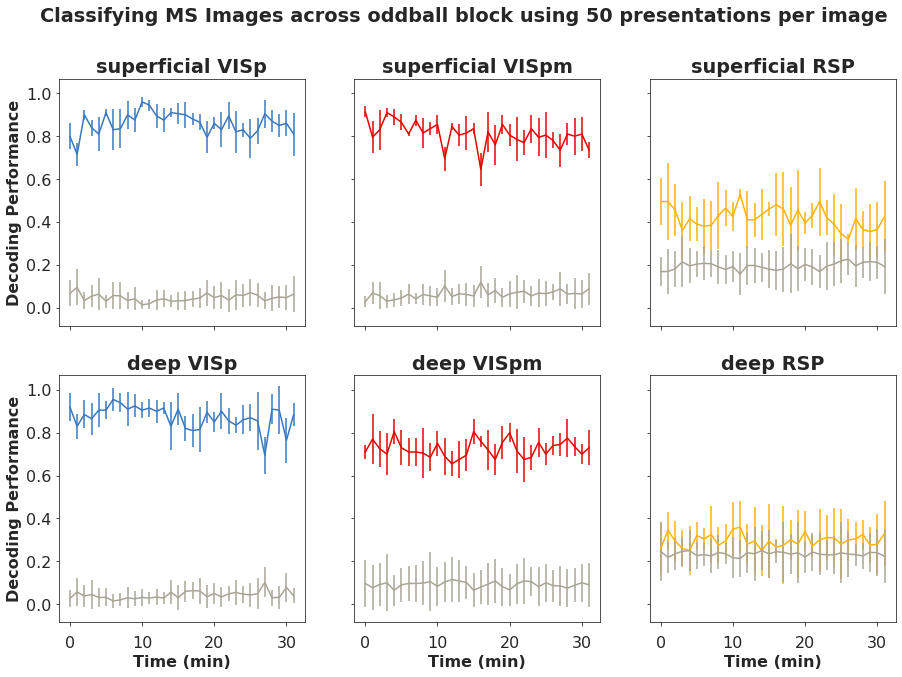

In [290]:
fig, axes = plt.subplots(2,3,figsize=(15,10),sharey=True,sharex=True)
plt.suptitle('Classifying MS Images across oddball block using 50 presentations per image')

for jj,depthstr in enumerate(['superficial','deep']):
    for ii,area in enumerate(areanames):
        locstr = '{}_{}'.format(area,depthstr)
        
        hits = diag_hits[jj][ii]
        miss = offdiag_hits[jj][ii]
        ax = axes[jj,ii]
        ax.errorbar(x=np.arange(32),y=np.mean(hits,axis=-1),yerr=np.std(hits,axis=-1),color=cc[ii])
        ax.errorbar(x=np.arange(32),y=np.mean(miss,axis=-1),yerr=np.std(miss,axis=-1),color=cc[8])
        ax.set_title('{} {}'.format(depthstr,area))
        
        if jj == 1:
            ax.set_xlabel('Time (min)')
        if ii == 0:
            ax.set_ylabel('Decoding Performance')

plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_TIMECOURSE_{}_{}.png'.format(method,classifier)))

In [288]:
PlotDir

'/home/dwyrick/projects/predictive_coding/results/decoding/neurons/drift/plots'

In [ ]:
method='kfold'

reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons/drift'
    PlotDir = os.path.join(SaveDir,'plots')
    
# slice_list = [slice(0,2000),slice(3000,5000),slice(6160,6400)]
# slice_str = ['first2000','middle2000','last240']
# sl_val = slice_list[1]
# sl_str = slice_str[1]

nClasses = 4
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

diag_hits_list = []
offdiag_hits_list = []
for iStart in range(0,6401,200):
    iEnd = iStart + 200
    print('start-{:03d}'.format(iStart))
    
    sl_val = slice(iStart, iEnd)
    sl_str = 'start-{:03d}'.format(iStart)
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        fig, axes = plt.subplots(1,3,figsize=(15,5))
        for ii,area in enumerate(areanames):
            cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
            locstr = '{}_{}'.format(area,depthstr)
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)


            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=sl_val)
    #         pdb.set_trace()
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X_oddball)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,clabels=mainseq_ids,classifier=classifier,method=method)

            else:
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,clabels=mainseq_ids,classifier=classifier,method=method,parallel=True)

             #Sparate diagonal and off-diagonal performance
            diag_hits_list.append(np.diag(confusion_mat))
            offdiag_hits_list.append(confusion_mat[off_diagonal_indy])

            fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=area,annot=True)
        plt.suptitle('Classifying MS Images for {} areas, Oddball block, {} classifier'.format(depthstr,classifier))
        plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_{}-areas_{}_{}_{}.png'.format(depthstr,sl_str,method,classifier)))

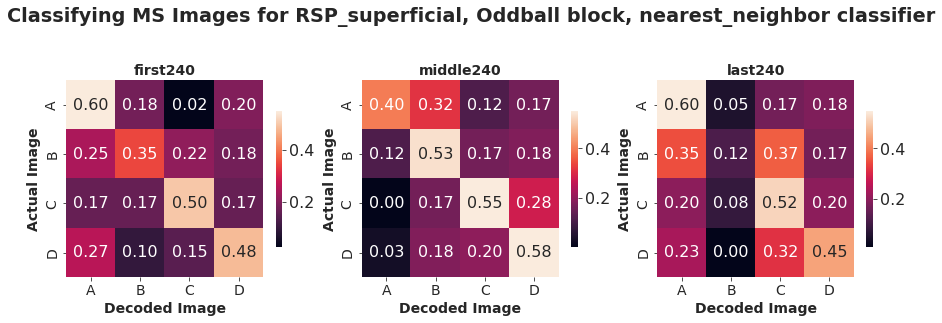

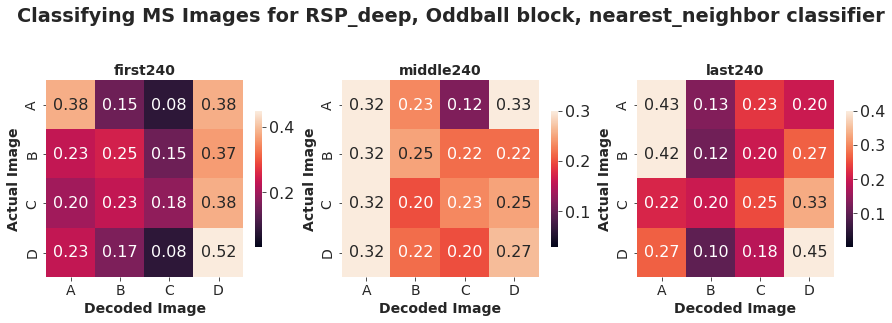

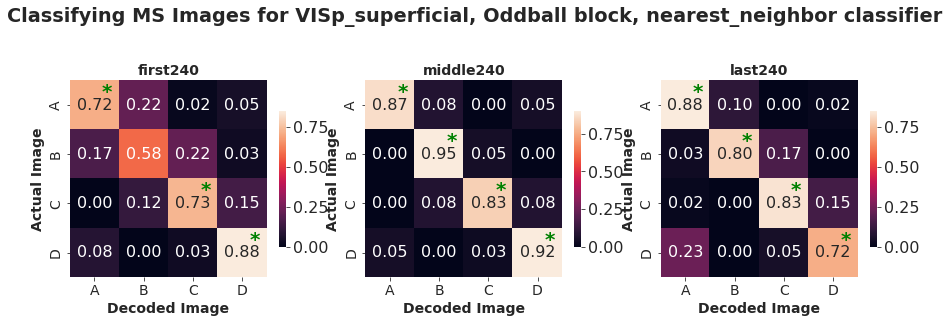

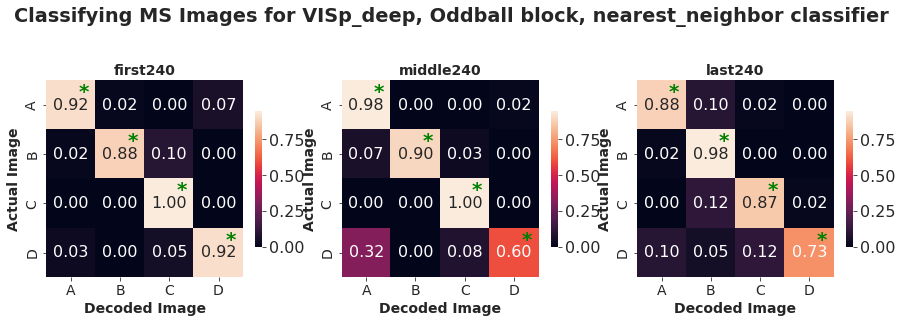

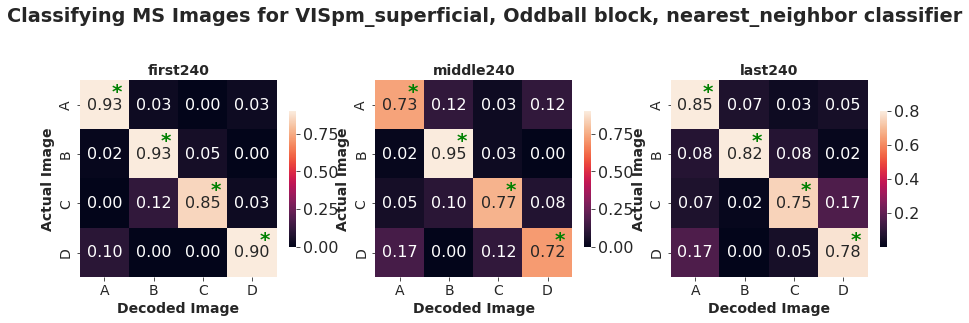

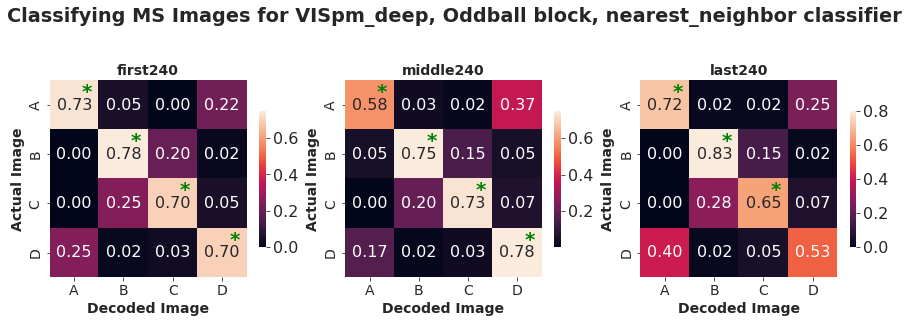

In [71]:
method='kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
method='kfold' 
classifier = 'LDA'
PlotDir = './plots/20200630_presentation'
slice_list = [slice(0,240),slice(3080,3320),slice(6160,6400)]
slice_str = ['first240','middle240','last240']

for area in areanames:
    cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        fig, axes = plt.subplots(1,3,figsize=(15,5))
        for ii,(sl_val,sl_str) in enumerate(zip(slice_list,slice_str)):
            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=sl_val)

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X_oddball)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,clabels=mainseq_ids,classifier=classifier,method=method)

            else:
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,clabels=mainseq_ids,classifier=classifier,method=method)

            fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(sl_str,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)


            dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=sl_str,annot=True)
        plt.suptitle('Classifying MS Images for {}, Oddball block, {} classifier'.format(locstr,classifier))
        plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_{}_{}_{}.png'.format(locstr,method,classifier)))

## What if we use all of the trials possible?

In [10]:
PlotDir = './plots/20200630_presentation'
mainseq_ids = [68, 78, 13, 26]
oddball_ids = [6, 17, 22, 51, 71, 89, 103, 110, 111, 112]

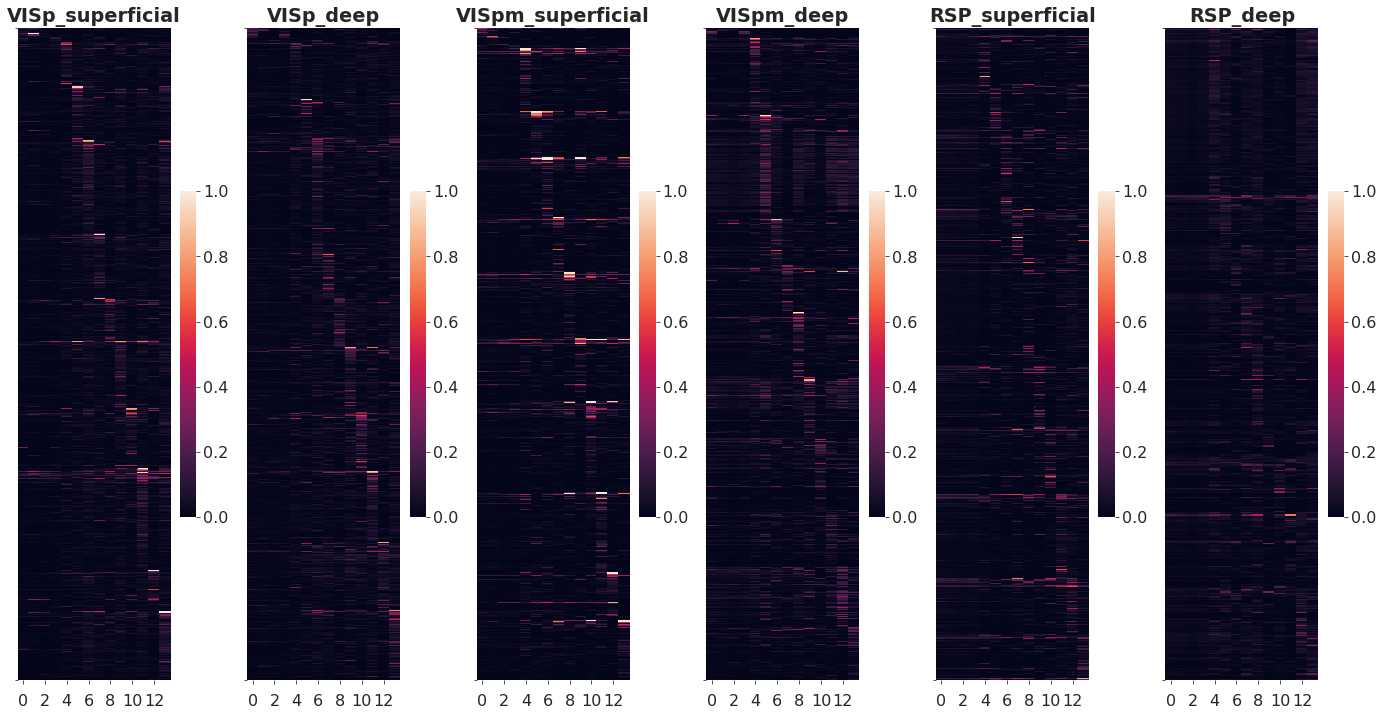

In [132]:
fig, axes = plt.subplots(1,6,figsize=(24,12))




are = 'RSP'
area = 'VISp'
iPlot = 0
for area in ['VISp','VISpm','RSP']:

    for depthstr in ['superficial','deep']:
        #Get cells that are in the right layer
        cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values

        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD')

        cell_list = []
        for imgID in mainseq_ids:
            #Get cell ids that prefer that image
            cellIDs_pref = cell_metadata_df.loc[(cell_metadata_df['pref_stim'] == imgID) & (cell_metadata_df['location'] == locstr)].index.values
            if len(cellIDs_pref) == 0:
                continue
            indy = np.where(Y_oddball == imgID)[0]
            mean_response = np.mean(X_oddball[indy][:800],axis=0)
            

            ss = np.argsort(np.array(mean_response.loc[cellIDs_pref]))[::-1]
            cell_list.append(cellIDs_pref[ss])

        #Calculate PSTH for main sequence images
        PSTH_list = []
        for imgID in mainseq_ids:
            indy = np.where(Y_oddball == imgID)[0]
            PSTH_list.append(np.mean(X_oddball[indy][800:],axis=0))


        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')

        for imgID in oddball_ids:
            #Get cell ids that prefer that image
            cellIDs_pref = cell_metadata_df.loc[(cell_metadata_df['pref_stim'] == imgID) & (cell_metadata_df['location'] == locstr)].index.values
            if len(cellIDs_pref) == 0:
                continue
            indy = np.where(Y_oddball == imgID)[0]
            mean_response = np.mean(X_oddball[indy][:5],axis=0)
#             pdb.set_trace()
            
            ss = np.argsort(np.array(mean_response.loc[cellIDs_pref]))[::-1]
            cell_list.append(cellIDs_pref[ss])


        #Calculate PSTH for main sequence images
        for imgID in oddball_ids:
            indy = np.where(Y_oddball == imgID)[0]
            PSTH_list.append(np.mean(X_oddball[indy][5:],axis=0))

        ordered_cellIDs =  np.concatenate(cell_list)

        orderedPSTHs = []
        for psth in PSTH_list:
            orderedPSTHs.append(psth.loc[ordered_cellIDs])

        PSTHs = np.stack(orderedPSTHs,axis=1)
        
        sns.heatmap(PSTHs,cmap='rocket',ax=axes[iPlot],vmax=1,vmin=0,cbar_kws={'shrink':0.5})
        axes[iPlot].set_title(locstr)
        axes[iPlot].set_yticks([0,len(cell_ids_perdepth)])
        axes[iPlot].set_yticklabels([0,len(cell_ids_perdepth)])
        iPlot += 1
#     plt.show()
#     pdb.set_trace()

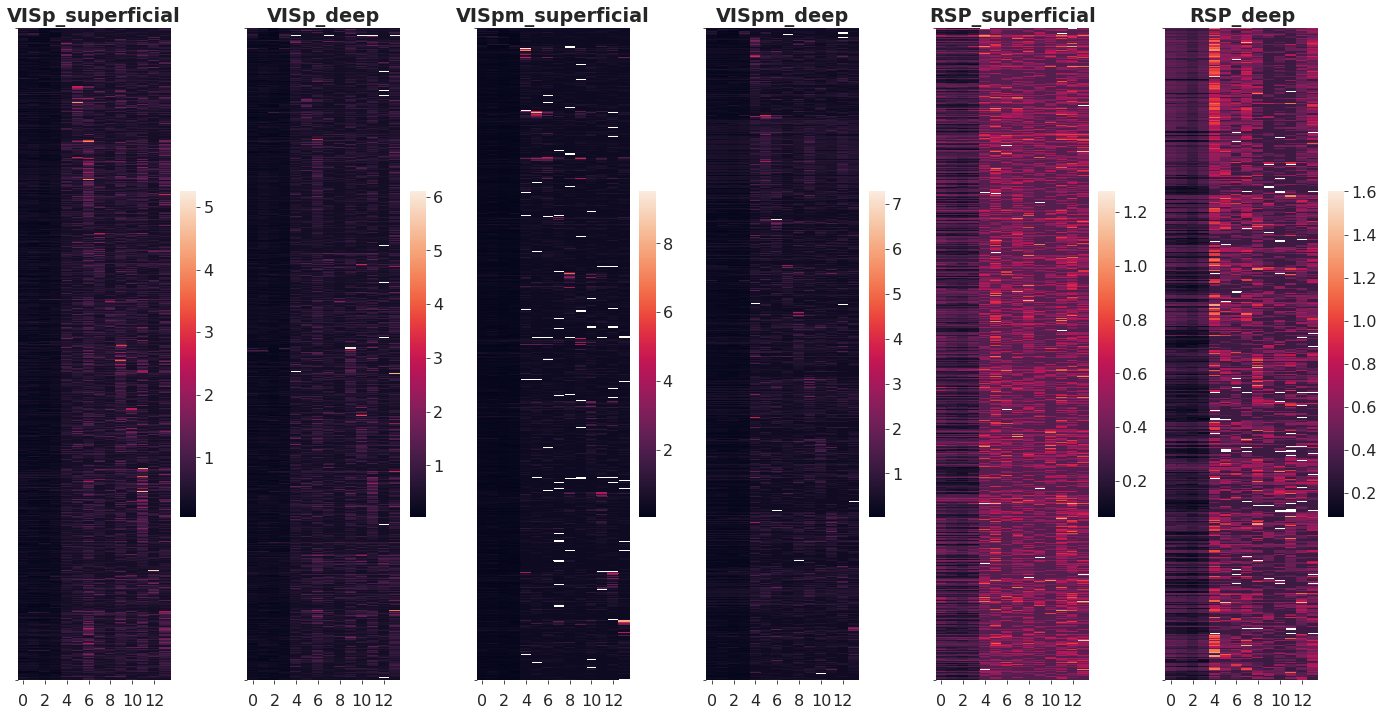

In [128]:
fig, axes = plt.subplots(1,6,figsize=(24,12))




are = 'RSP'
area = 'VISp'
iPlot = 0
for area in ['VISp','VISpm','RSP']:

    for depthstr in ['superficial','deep']:
        #Get cells that are in the right layer
        cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values

        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD')

        cell_list = []
        for imgID in mainseq_ids:
            #Get cell ids that prefer that image
            cellIDs_pref = cell_metadata_df.loc[(cell_metadata_df['pref_stim'] == imgID) & (cell_metadata_df['location'] == locstr)].index.values
            if len(cellIDs_pref) == 0:
                continue
            indy = np.where(Y_oddball == imgID)[0]
            mean_response = np.mean(X_oddball[indy],axis=0)

            ss = np.argsort(np.array(mean_response.loc[cellIDs_pref]))[::-1]
            cell_list.append(cellIDs_pref[ss])

        #Calculate PSTH for main sequence images
        PSTH_list = []
        for imgID in mainseq_ids:
            indy = np.where(Y_oddball == imgID)[0]
            PSTH_list.append(np.mean(X_oddball[indy],axis=0)/np.std(X_oddball[indy],axis=0))


        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')

        for imgID in oddball_ids:
            #Get cell ids that prefer that image
            cellIDs_pref = cell_metadata_df.loc[(cell_metadata_df['pref_stim'] == imgID) & (cell_metadata_df['location'] == locstr)].index.values
            if len(cellIDs_pref) == 0:
                continue
            indy = np.where(Y_oddball == imgID)[0]
            mean_response = np.mean(X_oddball[indy],axis=0)

            ss = np.argsort(np.array(mean_response.loc[cellIDs_pref]))[::-1]
            cell_list.append(cellIDs_pref[ss])


        #Calculate PSTH for main sequence images
        for imgID in oddball_ids:
            indy = np.where(Y_oddball == imgID)[0]
            PSTH_list.append(np.mean(X_oddball[indy],axis=0)/np.std(X_oddball[indy],axis=0))

        ordered_cellIDs =  np.concatenate(cell_list)

        orderedPSTHs = []
        for psth in PSTH_list:
            orderedPSTHs.append(psth.loc[ordered_cellIDs])

        PSTHs = np.stack(orderedPSTHs,axis=1)
        
        sns.heatmap(PSTHs,cmap='rocket',ax=axes[iPlot],cbar_kws={'shrink':0.5})
        axes[iPlot].set_title(locstr)
        axes[iPlot].set_yticks([0,len(cell_ids_perdepth)])
        iPlot += 1
#     plt.show()
#     pdb.set_trace()

In [36]:
PSTHs.shape

(14, 1278)

In [ ]:
#This cell takes a long long time because we're using all of the trials
classifier = 'nearest_neighbor'
method='kfold'
#Loop over depth as well
for depthstr in ['superficial','deep']:

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
    
        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, _ = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD')

        #Use pseudopopulation vectors for decoding
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,method=method,classifier=classifier,plot_shuffle=False,clabels=mainseq_ids)

        fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_alltrials_{}_{}.mat'.format(locstr,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D'],title=locstr,annot=True)
    plt.suptitle('Classifying MS Images in Oddball block, All trials, {} classifier'.format(classifier))
    plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_alltrials_{}-areas_{}.png'.format(locstr,classifier)))

## Oddball images from the random control block

In [ ]:
        for ii, pstr in enumerate(['pre','post']):
            block_str = 'randomized_control_{}'.format(pstr)

            #Get trials where MS images were presented from the randomized_ccontrol block
            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pseudopop_responses[area][ii].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='ABCD')

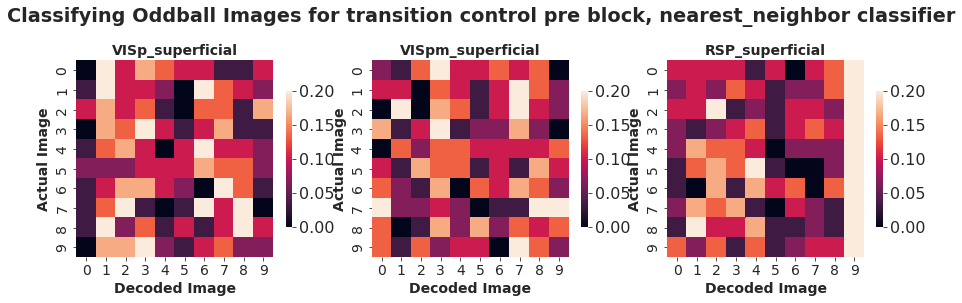

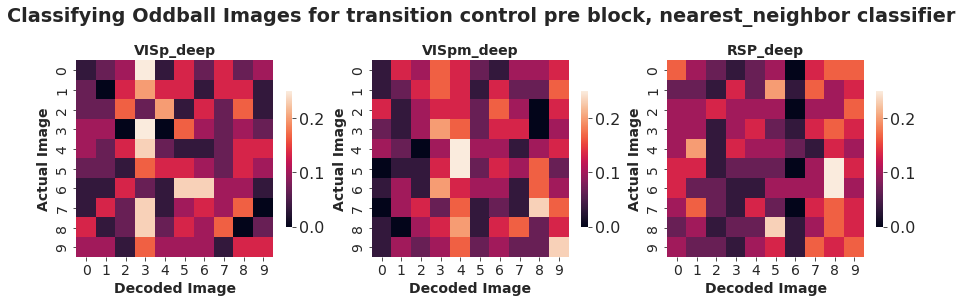

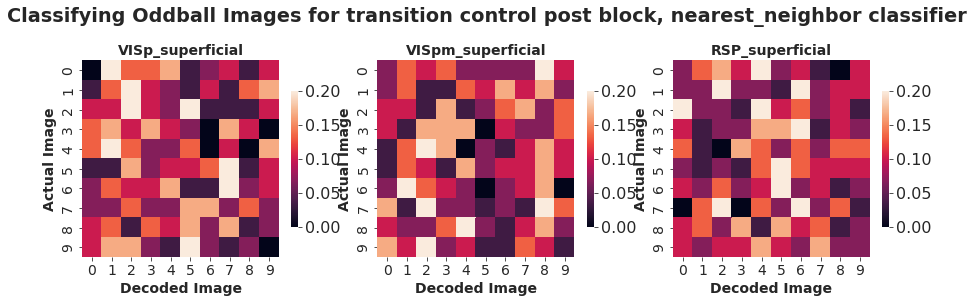

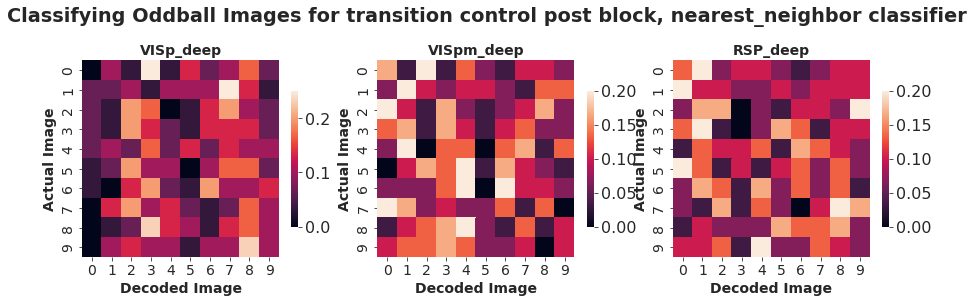

In [294]:
method = 'kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
for iP2, pstr in enumerate(['pre','post']):
    block_str = 'randomized_control_{}'.format(pstr)
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:

        fig, axes = plt.subplots(1,3,figsize=(15,5))
        for ii,area in enumerate(areanames):
            cell_ids = randctrl_pseudopop_responses[area][iP2].coords['cell_specimen_id'].values

            locstr = '{}_{}'.format(area,depthstr)
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)

            #Get trials where MS images were presented from the randomized_ccontrol block
            X_randctrl, Y_randctrl, Y_sort = dc.match_trials(randctrl_pseudopop_responses[area][iP2].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')
#             pdb.set_trace()
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X_oddball)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,method=method,nKfold=10,clabels=oddball_ids,classifier=classifier)

            else:
                #Use pseudopopulation vectors for decoding
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_randctrl,Y_randctrl,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=oddball_ids)

            fpath = os.path.join(SaveDir,'X-img_decoding_rand-ctrl-{}-block_{}_{}_{}.mat'.format(pstr,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat',data=confusion_mat)
                h5file.create_dataset('confusion_shf',data=confusion_shf)
                h5file.create_dataset('confusion_z',data=confusion_z)
                h5file.create_dataset('area',data=area)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

    #         with h5py.File(fpath,'r') as h5file:
    #             confusion_mat = np.array(h5file['confusion_mat'])
    #             confusion_z = np.array(h5file['confusion_z'])

            dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=np.arange(10),title=locstr,annot=False)
        plt.suptitle('Classifying Oddball Images for transition control {} block, {} classifier'.format(pstr,classifier),y=0.925)
        plt.savefig(os.path.join(PlotDir,'X-img_decoding_rand-ctrl-{}-blocks_{}-areas_{}_{}.png'.format(pstr,depthstr,method,classifier)))

## Oddball images from the transition control block

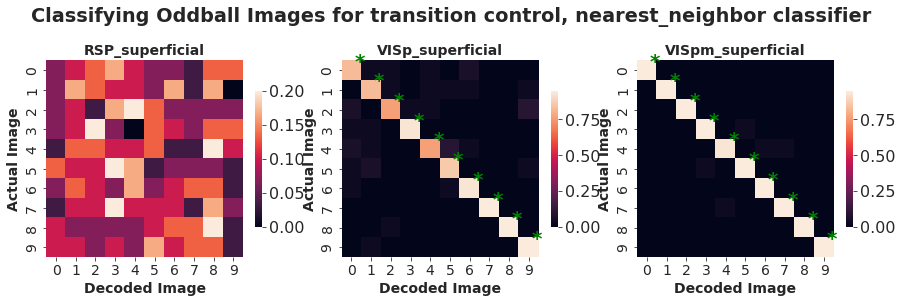

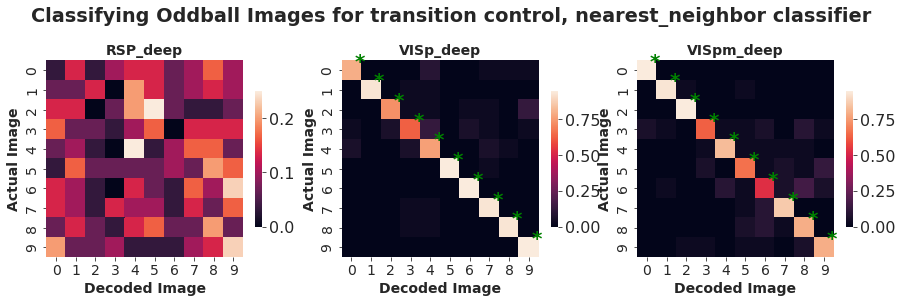

In [78]:

method = 'kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

#Loop over depth as well
for depthstr in ['superficial','deep']:

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = transctrl_pseudopop_responses[area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where odbball images were presented from the transition_control block
        X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')
#         pdb.set_trace()
        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_transctrl)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_transctrl,clabels=oddball_ids,classifier=classifier,method=method)

        else:
            #Use pseudopopulation vectors for decoding
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_transctrl,Y_transctrl,method='kfold',nKfold=10,classifier=classifier,clabels=oddball_ids)

        fpath = os.path.join(SaveDir,'X-img_decoding_transition-ctrl-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

#         with h5py.File(fpath,'r') as h5file:
#             confusion_mat = np.array(h5file['confusion_mat'])
#             confusion_z = np.array(h5file['confusion_z'])

        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=np.arange(10),title=locstr,annot=False)
    plt.suptitle('Classifying Oddball Images for transition control, {} classifier'.format(classifier),y=0.925)
    plt.savefig(os.path.join(PlotDir,'X-img_decoding_transctrl-blocks_{}_{}_{}.png'.format(locstr,method,classifier)))

## Oddball images from the oddball block

KeyboardInterrupt: 

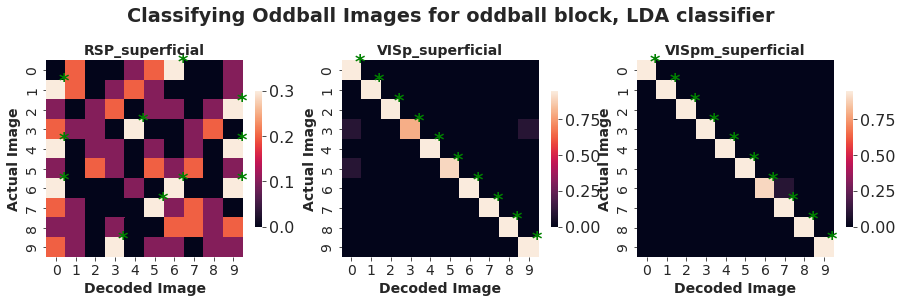

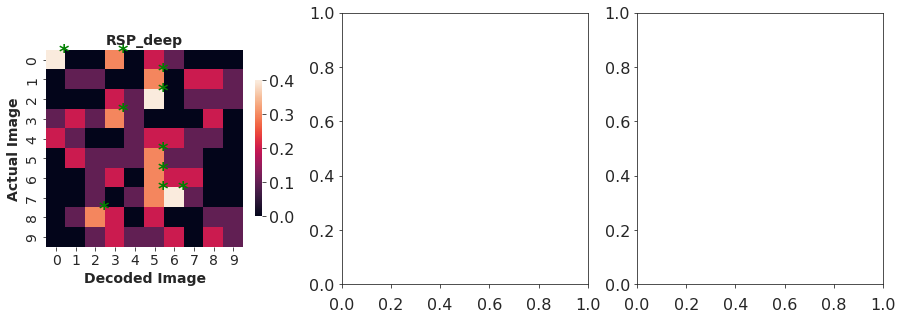

In [125]:
method = 'kfold'
reduce_dim=False

if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
PlotDir = './plots/20200630_presentation'
method = "L1O"
classifier = 'LDA'
#Loop over depth as well
for depthstr in ['superficial','deep']:

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')
#         pdb.set_trace()
        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_oddball)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,method=method,nKfold=10,clabels=oddball_ids,classifier=classifier)

        else:
            #Use pseudopopulation vectors for decoding
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=oddball_ids)

        fpath = os.path.join(SaveDir,'X-img_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

#         with h5py.File(fpath,'r') as h5file:
#             confusion_mat = np.array(h5file['confusion_mat'])
#             confusion_z = np.array(h5file['confusion_z'])

        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=np.arange(10),title=locstr,annot=False)
    plt.suptitle('Classifying Oddball Images for oddball block, {} classifier'.format(classifier),y=0.925)
    plt.savefig(os.path.join(PlotDir,'X-img_decoding_oddball-blocks_{}_{}_{}.png'.format(locstr,method,classifier)))

### Try to decode oddball images vs the previous main sequence in the oddball block
ABCD---X; i.e. the ABC trials are as far away from an oddball presentation as possible

In [147]:
PlotDir

'/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation/plots'

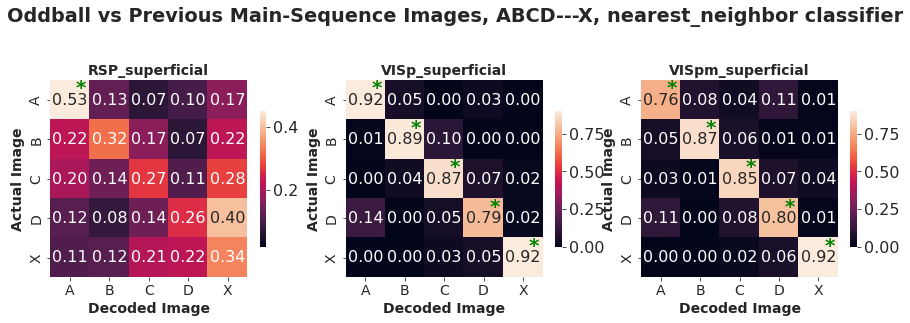

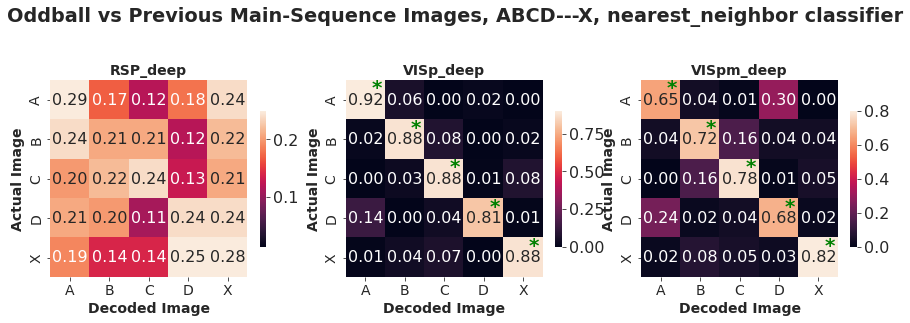

In [82]:
classifier = 'nearest_neighbor'

method = 'kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')
    
#Loop over depth as well
for depthstr in ['superficial','deep']:

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
 
        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCDX')
        
        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_oddball)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])

        else:
            #Use pseudopopulation vectors for decoding
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])
            

        fpath = os.path.join(SaveDir,'prevMSvsX_decoding_oddball-block_{}_{}.mat'.format(locstr,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
        
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D','X'],title=locstr,annot=True)
    plt.suptitle('Oddball vs Previous Main-Sequence Images, ABCD---X, {} classifier'.format(classifier))
    plt.savefig(os.path.join(PlotDir,'prevMSvsX_decoding_oddball-blocks_{}-areas_{}.png'.format(depthstr,classifier)))

### Try to decode oddball images vs the main sequence immediately following the oddball
XABCD i.e. the ABCD trials are as close to the oddball presentations as possible

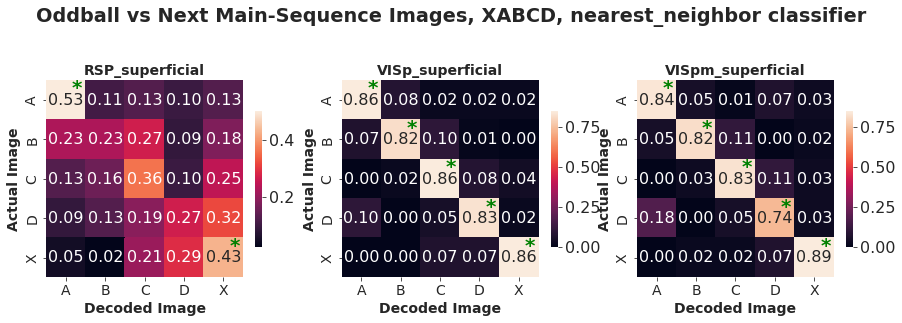

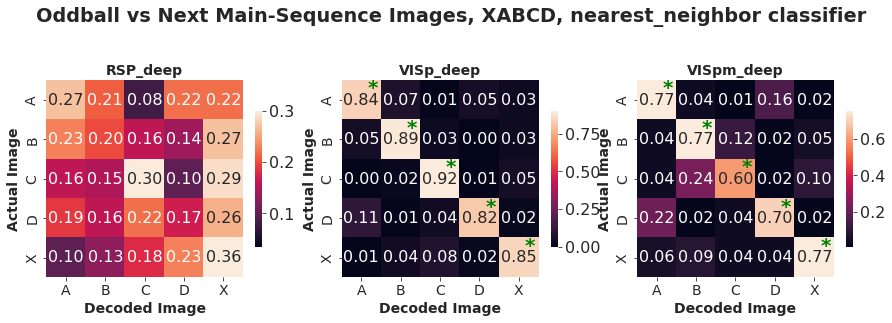

In [84]:
method = 'kfold'
reduce_dim=False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/PCA'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/neurons'
    PlotDir = os.path.join(SaveDir,'plots')

#Loop over depth as well
for depthstr in ['superficial','deep']:

    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        cell_ids = oddball_pseudopop_responses[area].coords['cell_specimen_id'].values
        
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
        
        #Get trials where MS images were presented from the middle of the oddball block
        X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pseudopop_responses[area].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='XABCD')

        if reduce_dim:
            #Reduce dimensionality using PCA
            pca = PCA(n_components=0.99)
            X_pca = pca.fit_transform(X_oddball)
            nComponents_pca = X_pca.shape[-1]

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])

        else:
            #Use pseudopopulation vectors for decoding
            confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,method=method,nKfold=10,classifier=classifier,clabels=[68, 78, 13, 26, 1])

        fpath = os.path.join(SaveDir,'nextMSvsX_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=['A','B','C','D','X'],title=locstr,annot=True)
    plt.suptitle('Oddball vs Next Main-Sequence Images, XABCD, {} classifier'.format(classifier))
    plt.savefig(os.path.join(PlotDir,'nextMSvsX_decoding_oddball-blocks_{}-areas_{}_{}.png'.format(depthstr,method,classifier)))